In [1]:
#Read in the necessary libraries
import pandas as pd
import numpy as np
import itertools

#Matplotlib section
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns

#SKlearn and Scipy Models
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

#Import for the creation and visualization of decision trees
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
from sklearn.metrics import make_scorer

#Import for random forest modeling
from sklearn.ensemble import RandomForestClassifier

In [2]:
import xgboost as xgb

#This code prevents the kernel from stopping when XGBoost is running
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

In [3]:
#I import pickle to save certain models
import pickle

In [4]:
#A function that takes in a model and a string with the model name and saves it to the repository
def make_pickle(model, model_name):
    model_pickle_path = 'Classification_Models_After_'+ model_name + '.pkl'
    # Create a variable to pickle and open it in write mode
    model_pickle = open(model_pickle_path, 'wb')
    pickle.dump(model, model_pickle)
    model_pickle.close()

In [5]:
#Read in the csv file containing the datafreame
election_df = pd.read_csv('congressional_data_and_targets.csv')

## 1. Create the Boolean Target Variable

The data cleansing process was completed in the notebook titled "Census_Data_API_Work.ipynb"

In [6]:
#Creates a boolean column based on whether the district voted more for the Republican party or not (i.e. Democratic party/ Independent candidate)
election_df['Target_Presidential_R_bool'] = (election_df['Target_Presidential_R'] > election_df['Target_Presidential_D']).astype(int)


In [7]:
election_df.shape

(860, 54)

In [8]:
#Reorganize the dataframe so the target variable is on the right side and the identification cells are on the left
election_df = election_df[['CD_Id_Year', 'District_Name', 'State', 'Total_Pop', 'Total_Males', 'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People', 'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian', 'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin', 'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US', 'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income', 'Median_Household_Income', 'Below_Poverty_Level_LTM', 'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool', 'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree', 'Total_Married_Households', 'Total_Veterans', 'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed', 'Median_Age_Of_Worker', 'Total_Workers', 'Total_Working_Agricult', 'Total_Working_Construction', 'Total_Working_Manufacturing', 'Total_Working_Retail', 'Total_Working_Transportation', 'Total_Working_Information', 'Total_Working_Finance', 'Total_Working_Education', 'Total_Working_Health', 'Total_Working_Food', 'Total_Working_Public_Admin', 'Median_Gross_Rent', 'Target_Presidential_R_bool']]

## 2. EDA

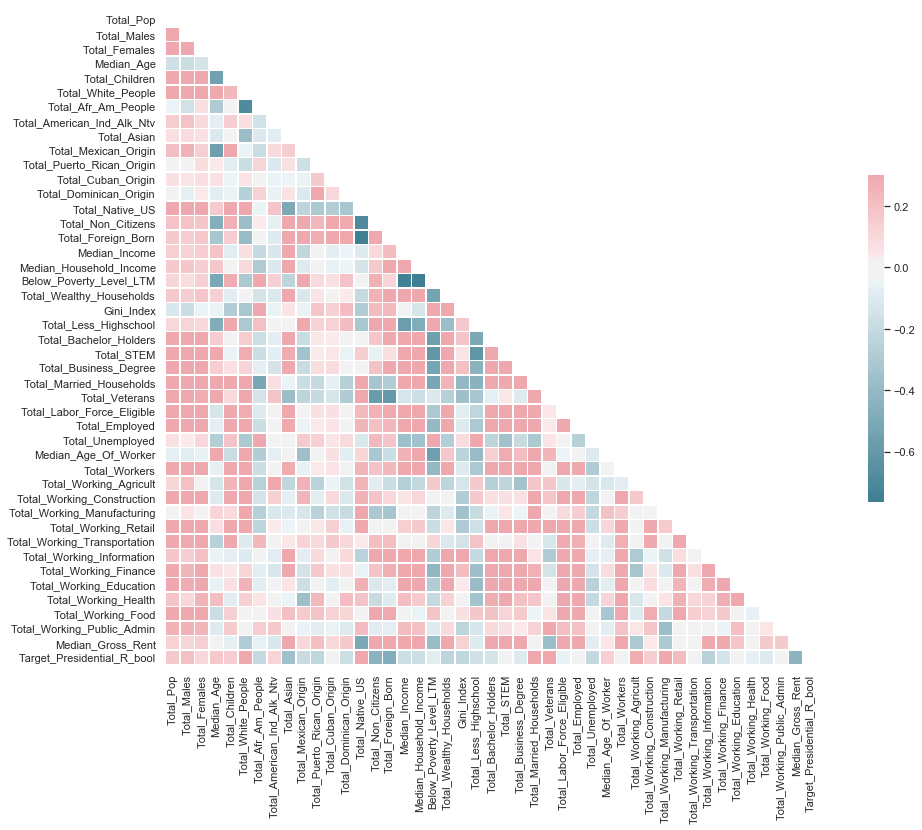

In [9]:
#This cell creates a correlation matrix to view the correlation between continuous features
#and the target variable
sns.set(style="white")

# Compute the correlation matrix
corr = election_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

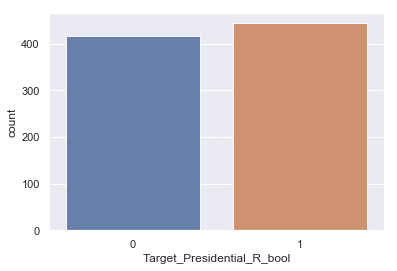

In [10]:
#A histogram of the target variable
sns.set_style('darkgrid')
sns.countplot(election_df['Target_Presidential_R_bool'], alpha=0.9)
#There is a negligible imbalance

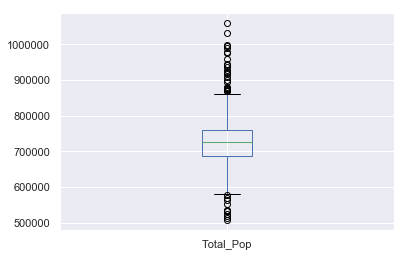

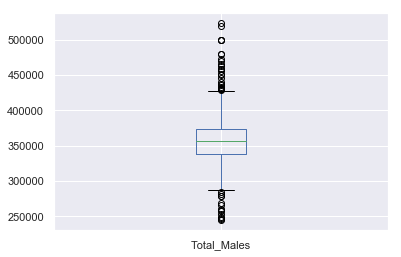

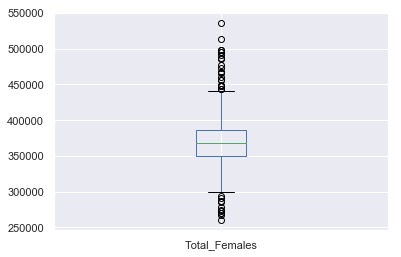

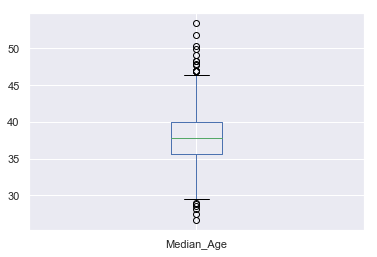

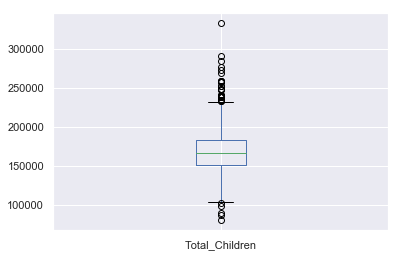

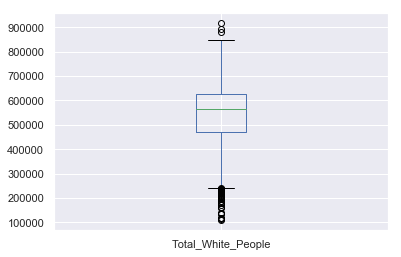

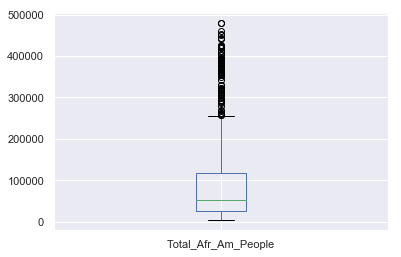

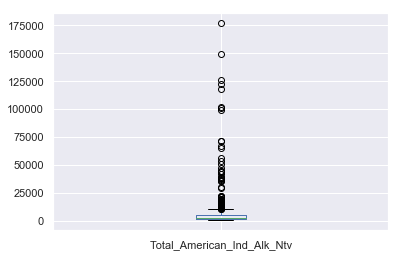

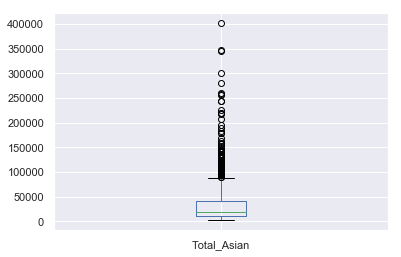

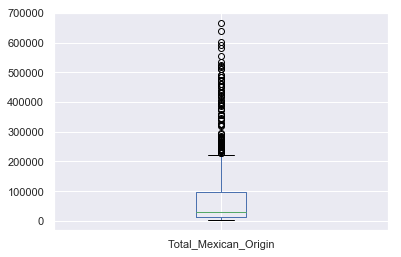

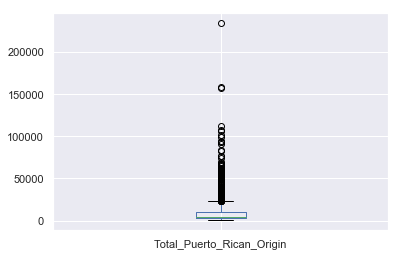

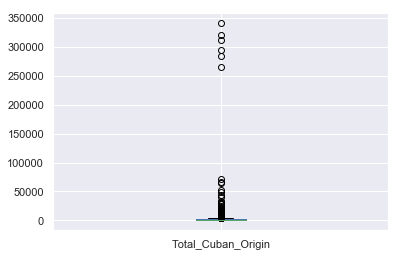

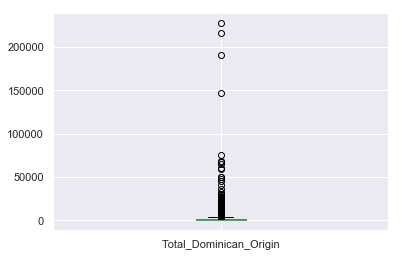

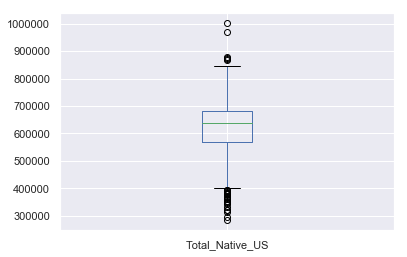

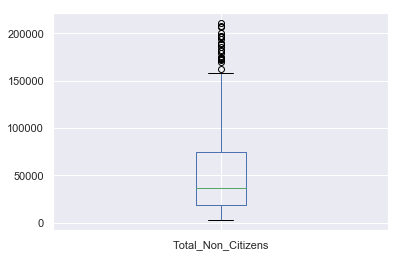

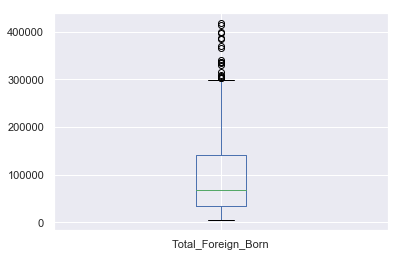

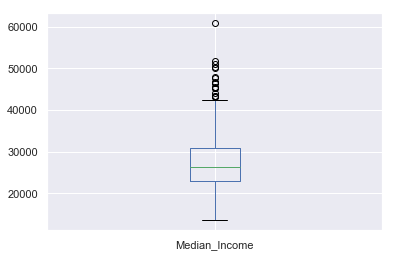

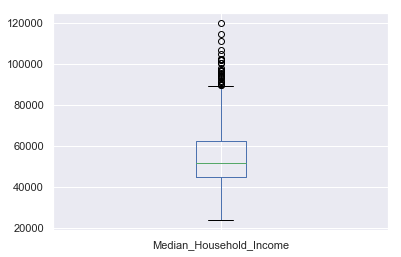

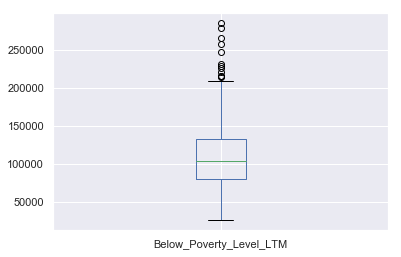

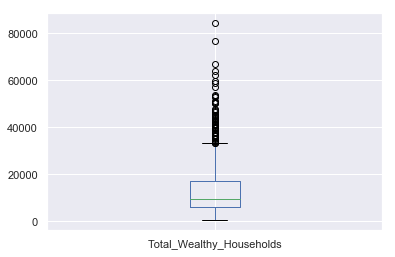

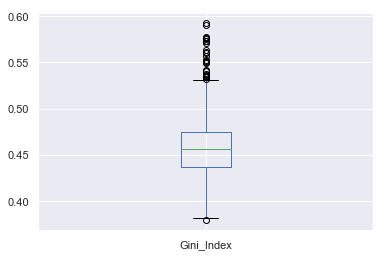

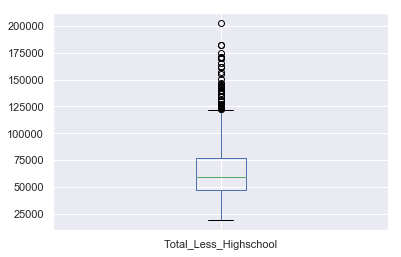

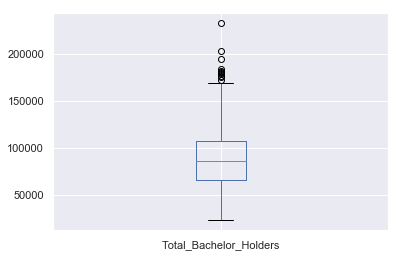

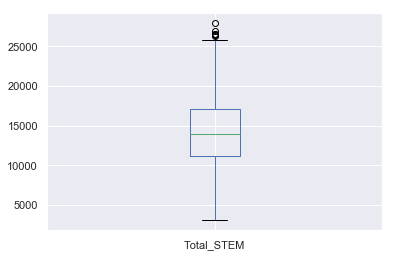

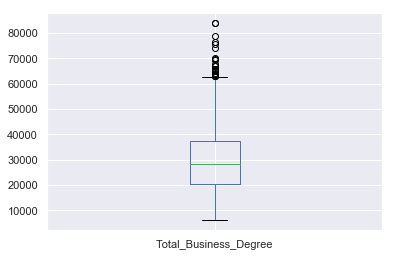

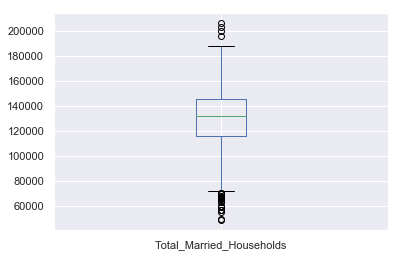

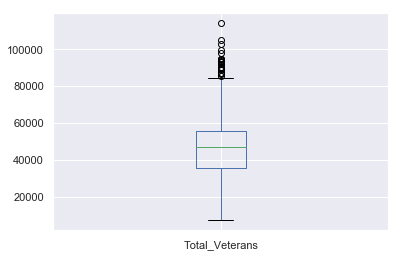

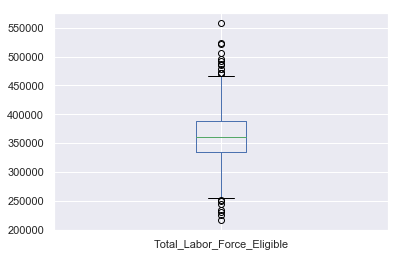

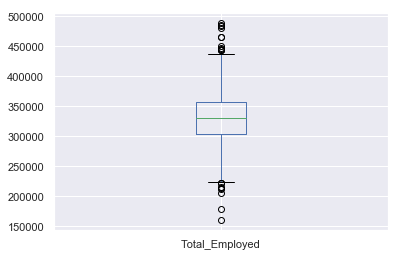

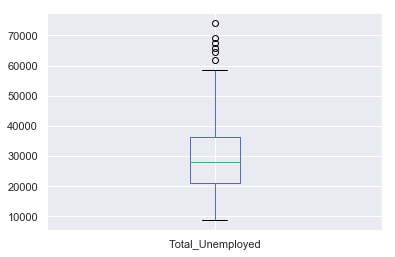

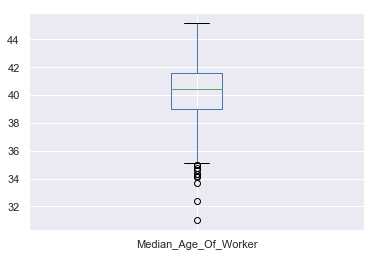

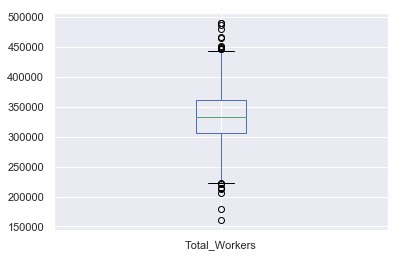

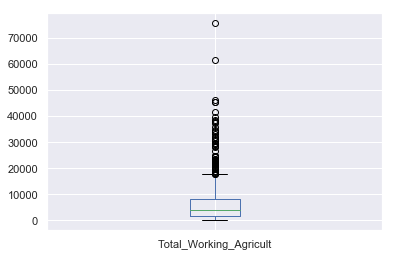

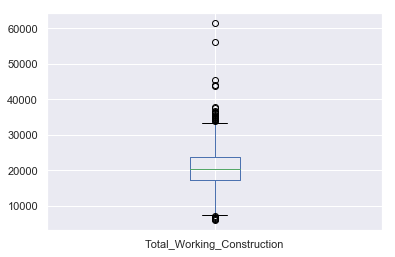

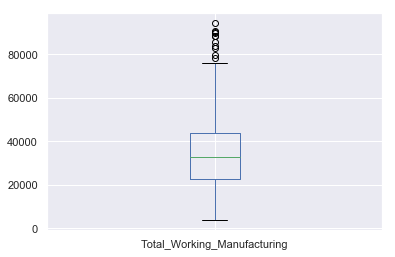

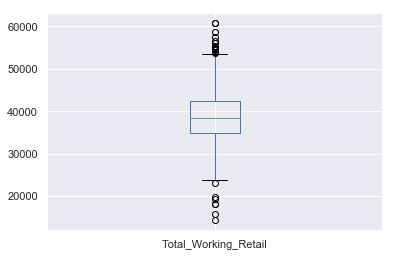

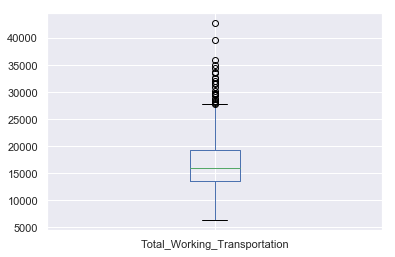

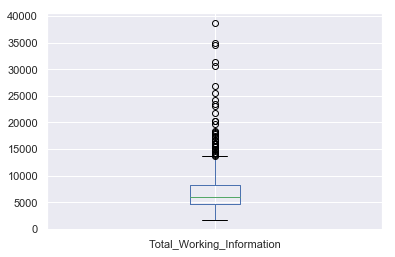

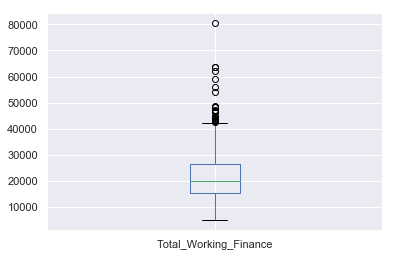

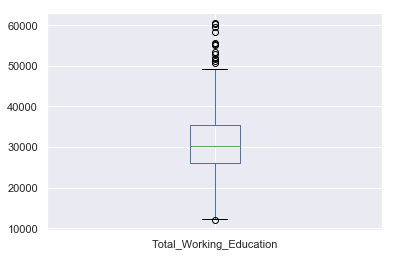

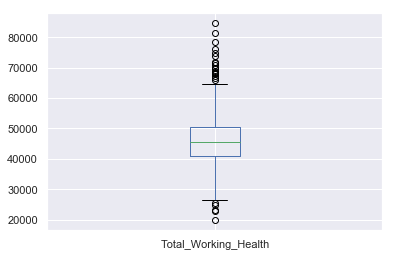

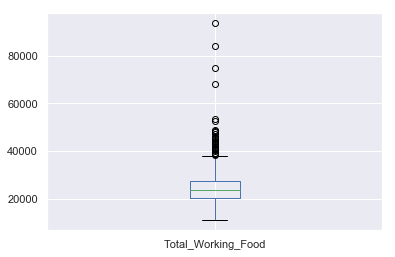

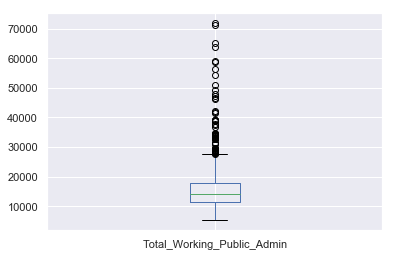

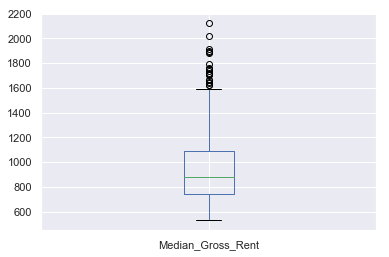

In [11]:
#Boxplots of all continuous variables as individual graphs
for i in election_df.columns[3:-1]:
    election_df.boxplot(column=i)
    plt.show()

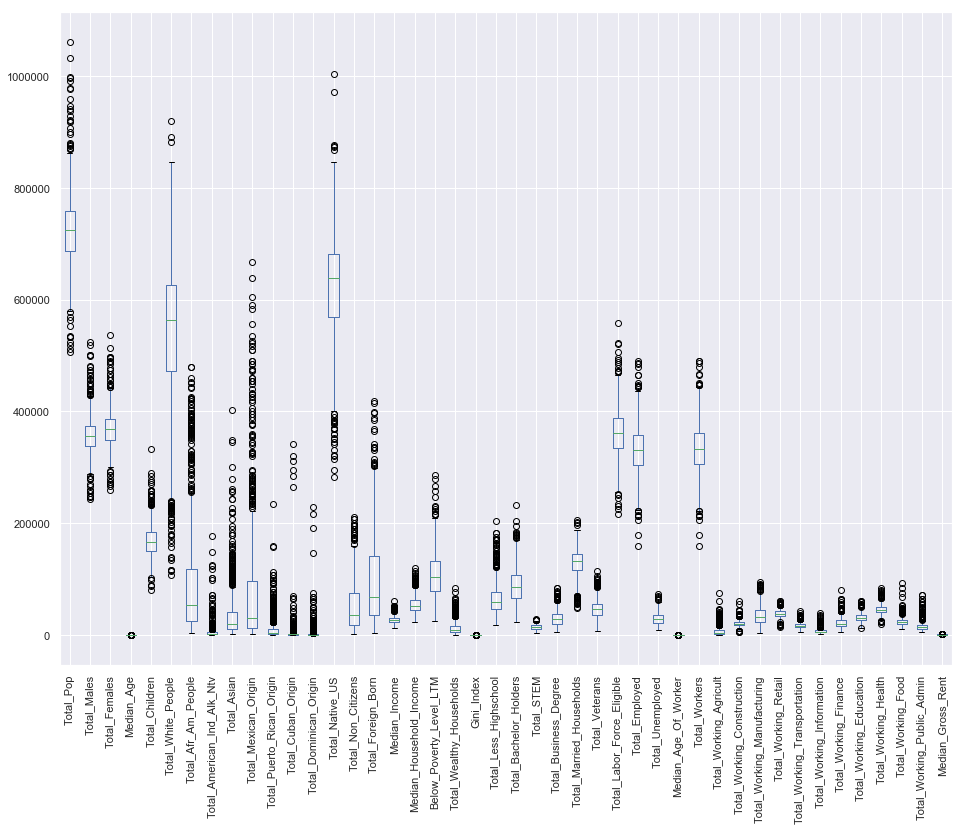

In [12]:
#A Boxplot of all continuous variables in one graph
election_df[['CD_Id_Year', 'District_Name', 'State', 'Total_Pop', 'Total_Males', 'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People', 'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian', 'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin', 'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US', 'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income', 'Median_Household_Income', 'Below_Poverty_Level_LTM', 'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool', 'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree', 'Total_Married_Households', 'Total_Veterans', 'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed', 'Median_Age_Of_Worker', 'Total_Workers', 'Total_Working_Agricult', 'Total_Working_Construction', 'Total_Working_Manufacturing', 'Total_Working_Retail', 'Total_Working_Transportation', 'Total_Working_Information', 'Total_Working_Finance', 'Total_Working_Education', 'Total_Working_Health', 'Total_Working_Food', 'Total_Working_Public_Admin', 'Median_Gross_Rent']].boxplot(figsize = (16,12), rot= 90)

## 3. Feature Engineering

In [13]:
election_df.describe()

Total_Pop    Total_Males  Total_Females  Median_Age  Total_Children  \
count  8.600000e+02     860.000000     860.000000  860.000000      860.000000   
mean   7.268451e+05  357600.737209  369244.387209   37.820233   169483.191860   
std    6.619435e+04   34433.479928   33183.422698    3.590825    29622.251731   
min    5.060360e+05  244165.000000  259717.000000   26.600000    79905.000000   
25%    6.869985e+05  338342.750000  349492.750000   35.700000   150886.250000   
50%    7.251775e+05  356798.000000  367634.500000   37.800000   166010.500000   
75%    7.589910e+05  374238.500000  386822.250000   40.025000   183537.500000   
max    1.060651e+06  524241.000000  536410.000000   53.500000   333258.000000   

       Total_White_People  Total_Afr_Am_People  Total_American_Ind_Alk_Ntv  \
count          860.000000           860.000000                  860.000000   
mean        533979.023256         92016.222093                 5950.669767   
std         135143.070581        101111.608945                14154.258727   
min         108156.000000          3031.000000                  204.000000   
25%         471771.000000         25725.000000                 1466.500000   
50%         562842.000000         52870.000000                 2542.000000   
75%         626446.000000        117343.500000                 5004.000000   
max         918701.000000        480259.000000               177468.000000   

         Total_Asian  Total_Mexican_Origin  ...  Total_Working_Retail  \
count     860.000000            860.000000  ...            860.000000   
mean    37313.330233          80489.416279  ...          38597.729070   
std     46828.288462         115513.394277  ...           6175.211488   
min      1582.000000           1644.000000  ...          14239.000000   
25%     11112.250000          13003.750000  ...          34765.500000   
50%     19595.500000          29654.500000  ...          38422.000000   
75%     41617.000000          96621.750000  ...          42339.750000   
max    402466.000000         667403.000000  ...          60866.000000   

       Total_Working_Transportation  Total_Working_Information  \
count                    860.000000                 860.000000   
mean                   16837.897674                7027.823256   
std                     4841.726770                3957.953694   
min                     6275.000000                1572.000000   
25%                    13515.250000                4568.000000   
50%                    15945.000000                6045.000000   
75%                    19211.750000                8227.500000   
max                    42850.000000               38750.000000   

       Total_Working_Finance  Total_Working_Education  Total_Working_Health  \
count             860.000000               860.000000            860.000000   
mean            21897.318605             30998.567442          45973.329070   
std              8880.305939              7304.605726           8275.721264   
min              4898.000000             11937.000000          19790.000000   
25%             15569.250000             26153.750000          40786.000000   
50%             20156.500000             30256.500000          45551.000000   
75%             26312.750000             35481.500000          50479.500000   
max             80628.000000             60628.000000          84767.000000   

       Total_Working_Food  Total_Working_Public_Admin  Median_Gross_Rent  \
count          860.000000                  860.000000         860.000000   
mean         24927.781395                16047.937209         941.208140   
std           7152.465737                 8063.942992         263.963379   
min          10929.000000                 5196.000000         528.000000   
25%          20498.250000                11266.750000         740.750000   
50%          23704.500000                14209.000000         875.500000   
75%          27580.500000                17775.500000        1092.750000   
max 

In [14]:
#In this cell I turn subsets of the total population into percentages of the
#population and  workforce/labor force

#Identify columns to divide by population segemnts

to_divide_by_total_pop = ['Total_Males', 'Total_Females', 'Total_Veterans', 'Total_White_People', 'Total_Afr_Am_People', 'Total_Asian', 'Total_American_Ind_Alk_Ntv', 'Total_Cuban_Origin', 'Total_Puerto_Rican_Origin', 'Total_Dominican_Origin', 'Total_Mexican_Origin', 'Total_Native_US', 'Total_Non_Citizens', 'Total_Foreign_Born', 'Total_Children', 'Total_Married_Households', 'Total_Less_Highschool', 'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree', 'Total_Labor_Force_Eligible', 'Below_Poverty_Level_LTM', 'Total_Workers']
to_divide_by_total_labor_force_eligible = ['Total_Employed', 'Total_Unemployed']
to_divide_by_total_workers = ['Total_Working_Agricult', 'Total_Working_Construction', 'Total_Working_Manufacturing', 'Total_Working_Retail', 'Total_Working_Transportation', 'Total_Working_Finance', 'Total_Working_Education', 'Total_Working_Health', 'Total_Working_Food', 'Total_Working_Public_Admin', 'Total_Working_Information']

#Normalize the data by making certain columns a percentage of one of the three main population groups

election_df[to_divide_by_total_workers] = election_df[to_divide_by_total_workers].div(election_df['Total_Workers'], axis=0)
election_df[to_divide_by_total_labor_force_eligible] = election_df[to_divide_by_total_labor_force_eligible].div(election_df['Total_Labor_Force_Eligible'], axis=0)
election_df[to_divide_by_total_pop] = election_df[to_divide_by_total_pop].div(election_df['Total_Pop'], axis=0)

In [15]:
#I create a second dataframe made of my engineered features and compare the results of
#each dataframe
election_df_feature_engineering = election_df.copy()
election_df_feature_engineering.columns

Index(['CD_Id_Year', 'District_Name', 'State', 'Total_Pop', 'Total_Males',
       'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People',
       'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian',
       'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin',
       'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US',
       'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income',
       'Median_Household_Income', 'Below_Poverty_Level_LTM',
       'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool',
       'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree',
       'Total_Married_Households', 'Total_Veterans',
       'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed',
       'Median_Age_Of_Worker', 'Total_Workers', 'Total_Working_Agricult',
       'Total_Working_Construction', 'Total_Working_Manufacturing',
       'Total_Working_Retail', 'Total_Working_Transportation',
       'Total_Working_Informat

In [16]:
#Create booleans if more than ten percent of a district's labor force work in a specific industry
election_df_feature_engineering['Ten_Percent_Manufacturing'] = np.where(election_df_feature_engineering['Total_Working_Manufacturing']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Manufacturing.value_counts())

election_df_feature_engineering['Ten_Percent_Agricult'] = np.where(election_df_feature_engineering['Total_Working_Agricult']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Agricult.value_counts())

election_df_feature_engineering['Ten_Percent_Construction'] = np.where(election_df_feature_engineering['Total_Working_Construction']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Construction.value_counts())

election_df_feature_engineering['Ten_Percent_Retail'] = np.where(election_df_feature_engineering['Total_Working_Retail']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Retail.value_counts())

election_df_feature_engineering['Ten_Percent_Information'] = np.where(election_df_feature_engineering['Total_Working_Information']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Information.value_counts())

election_df_feature_engineering['Ten_Percent_Transportation'] = np.where(election_df_feature_engineering['Total_Working_Transportation']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Transportation.value_counts())

election_df_feature_engineering['Ten_Percent_Finance'] = np.where(election_df_feature_engineering['Total_Working_Finance']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Finance.value_counts())

election_df_feature_engineering['Ten_Percent_Education'] = np.where(election_df_feature_engineering['Total_Working_Education']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Education.value_counts())

election_df_feature_engineering['Ten_Percent_Health'] = np.where(election_df_feature_engineering['Total_Working_Health']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Health.value_counts())

election_df_feature_engineering['Ten_Percent_Food'] = np.where(election_df_feature_engineering['Total_Working_Food']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Food.value_counts())


#Drops the columns that the above booleans were derived from
election_df_feature_engineering.drop(['Total_Working_Agricult',
       'Total_Working_Construction', 'Total_Working_Manufacturing',
       'Total_Working_Retail', 'Total_Working_Transportation',
       'Total_Working_Information', 'Total_Working_Finance',
       'Total_Working_Education', 'Total_Working_Health', 'Total_Working_Food',
       'Total_Working_Public_Admin'], axis=1)


0    438
1    422
Name: Ten_Percent_Manufacturing, dtype: int64
0    847
1     13
Name: Ten_Percent_Agricult, dtype: int64
0    846
1     14
Name: Ten_Percent_Construction, dtype: int64
1    771
0     89
Name: Ten_Percent_Retail, dtype: int64
0    860
Name: Ten_Percent_Information, dtype: int64
0    853
1      7
Name: Ten_Percent_Transportation, dtype: int64
0    803
1     57
Name: Ten_Percent_Finance, dtype: int64
0    605
1    255
Name: Ten_Percent_Education, dtype: int64
1    826
0     34
Name: Ten_Percent_Health, dtype: int64
0    797
1     63
Name: Ten_Percent_Food, dtype: int64


CD_Id_Year                                      District_Name State  \
0    CT-01-2016  Congressional District 1 (114th Congress), Con...    CT   
1    CT-02-2016  Congressional District 2 (114th Congress), Con...    CT   
2    CT-03-2016  Congressional District 3 (114th Congress), Con...    CT   
3    CT-04-2016  Congressional District 4 (114th Congress), Con...    CT   
4    CT-05-2016  Congressional District 5 (114th Congress), Con...    CT   
5    DE-AL-2016  Congressional District (at Large) (114th Congr...    DE   
6    DC-98-2016  Delegate District (at Large) (114th Congress),...    DC   
7    FL-01-2016  Congressional District 1 (114th Congress), Flo...    FL   
8    FL-02-2016  Congressional District 2 (114th Congress), Flo...    FL   
9    FL-03-2016  Congressional District 3 (114th Congress), Flo...    FL   
10   FL-04-2016  Congressional District 4 (114th Congress), Flo...    FL   
11   FL-05-2016  Congressional District 5 (114th Congress), Flo...    FL   
12   FL-06-2016  Congressional District 6 (114th Congress), Flo...    FL   
13   FL-07-2016  Congressional District 7 (114th Congress), Flo...    FL   
14   FL-08-2016  Congressional District 8 (114th Congress), Flo...    FL   
15   FL-09-2016  Congressional District 9 (114th Congress), Flo...    FL   
16   FL-10-2016  Congressional District 10 (114th Congress), Fl...    FL   
17   FL-11-2016  Congressional District 11 (114th Congress), Fl...    FL   
18   FL-12-2016  Congressional District 12 (114th Congress), Fl...    FL   
19   FL-13-2016  Congressional District 13 (114th Congress), Fl...    FL   
20   FL-14-2016  Congressional District 14 (114th Congress), Fl...    FL   
21   FL-15-2016  Congressional District 15 (114th Congress), Fl...    FL   
22   FL-16-2016  Congressional District 16 (114th Congress), Fl...    FL   
23   FL-17-2016  Congressional District 17 (114th Congress), Fl...    FL   
24   FL-18-2016  Congressional District 18 (114th Congress), Fl...    FL   
25   FL-19-2016  Congressional District 19 (114th Congress), Fl...    FL   
26   FL-20-2016  Congressional District 20 (114th Congress), Fl...    FL   
27   FL-21-2016  Congressional District 21 (114th Congress), Fl...    FL   
28   FL-22-2016  Congressional District 22 (114th Congress), Fl...    FL   
29   FL-23-2016  Congressional District 23 (114th Congress), Fl...    FL   
..          ...                                                ...   ...   
830  VA-03-2012  Congressional District 3 (112th Congress), Vir...    VA   
831  VA-04-2012  Congressional District 4 (112th Congress), Vir...    VA   
832  VA-05-2012  Congressional District 5 (112th Congress), Vir...    VA   
833  VA-06-2012  Congressional District 6 (112th Congress), Vir...    VA   
834  VA-07-2012  Congressional District 7 (112th Congress), Vir...    VA   
835  VA-08-2012  Congressional District 8 (112th Congress), Vir...    VA   
836  VA-09-2012  Congressional District 9 (112th Congress), Vir...    VA   
837  VA-10-2012  Congressional District 10 (112th Congress), Vi...    VA   
838  VA-11-2012  Congressional District 11 (112th Congress), Vi...    VA   
839  WA-01-2012  Congressional District 1 (112th Congress), Was...    WA   
840  WA-02-2012  Congressional District 2 (112th Congress), Was...    WA   
841  WA-03-2012  Congressional District 3 (112th Congress), Was...    WA   
842  WA-04-2012  Congressional District 4 (112th Congress), Was...    WA   
843  WA-05-2012  Congressional District 5 (112th Congress), Was...    WA   
844  WA-06-2012  Congressional District 6 (112th Congress), Was...    WA   
845  WA-07-2012  Congressional District 7 (112th Congress), Was...    WA   
846  WA-08-2012  Congressional District 8 (112th Congress), Was...    WA   
847  WA-09-2012  Congressional District 9 (112th Congress), Was...    WA   
848  WV-01-2012  Congressional District 1 (112th Congress), Wes...    WV   
849  WV-02-2012  Congressional District 2 (112th Congress), Wes...    WV   
850  WV-03-2012  Congressional District 3 (112th Cong

In [17]:
#Drop the original columns that the threshold columns were created from
election_df_feature_engineering = election_df_feature_engineering.drop(['Total_Working_Agricult',
       'Total_Working_Construction', 'Total_Working_Manufacturing',
       'Total_Working_Retail', 'Total_Working_Transportation',
       'Total_Working_Information', 'Total_Working_Finance',
       'Total_Working_Education', 'Total_Working_Health', 'Total_Working_Food',
       'Total_Working_Public_Admin'], axis=1)

#Drop the information boolean column because no district contains more than ten
#percent of the labor force working in that field
election_df_feature_engineering = election_df_feature_engineering.drop(['Ten_Percent_Information'], axis=1)

In [18]:
election_df_feature_engineering.columns

Index(['CD_Id_Year', 'District_Name', 'State', 'Total_Pop', 'Total_Males',
       'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People',
       'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian',
       'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin',
       'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US',
       'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income',
       'Median_Household_Income', 'Below_Poverty_Level_LTM',
       'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool',
       'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree',
       'Total_Married_Households', 'Total_Veterans',
       'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed',
       'Median_Age_Of_Worker', 'Total_Workers', 'Median_Gross_Rent',
       'Target_Presidential_R_bool', 'Ten_Percent_Manufacturing',
       'Ten_Percent_Agricult', 'Ten_Percent_Construction',
       'Ten_Percent_Retail', 'Ten_Percent

In [19]:
#Reorganize the second dataframe
election_df_feature_engineering = election_df_feature_engineering[['CD_Id_Year', 'District_Name', 'State', 'Total_Pop', 'Total_Males',
       'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People',
       'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian',
       'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin',
       'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US',
       'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income',
       'Median_Household_Income', 'Below_Poverty_Level_LTM',
       'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool',
       'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree',
       'Total_Married_Households', 'Total_Veterans',
       'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed',
       'Median_Age_Of_Worker', 'Total_Workers', 'Ten_Percent_Manufacturing',
       'Ten_Percent_Agricult', 'Ten_Percent_Construction',
       'Ten_Percent_Retail', 'Ten_Percent_Transportation',
       'Ten_Percent_Finance', 'Ten_Percent_Education', 'Ten_Percent_Health',
       'Ten_Percent_Food', 'Median_Gross_Rent', 'Target_Presidential_R_bool']]

## 4. A Function To Plot The Confusion Matrix

In [20]:
#This function will be used to create confusion matrices for each model where appropriate
def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    classes = ['Did Not Vote Republican', 'Voted Republican']
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': 22})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## 5. Initial Regression - Without Feature Engineering

In [21]:
#This is an initial logistic regression of all dependent variables using Scikit learn
#Using the dataframe without feature engineering

#Split data to be used in the models between the target variable and features

# X will take every dependent variable but the target and other index variables
X_log_model_1 = election_df.drop(['Target_Presidential_R_bool','CD_Id_Year', 'District_Name', 'State'], axis = 1) 

#y will hold the target variable
y_log_model_1 = election_df['Target_Presidential_R_bool'] # y is the column we're trying to predict

In [22]:
#Split the data into a train and test set
X_train_log_model_1, X_test_log_model_1, y_train_log_model_1, y_test_log_model_1 = train_test_split(X_log_model_1, y_log_model_1, random_state=1)


sc_log_model_1=StandardScaler()
X_train_scaled_log_model_1 = sc_log_model_1.fit_transform(X_train_log_model_1)
X_test_scaled_log_model_1 = sc_log_model_1.transform(X_test_log_model_1)


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys


In [23]:
#Fit the model and view the coefficients
log_model_1 = LogisticRegression(C=1e9)
log_model_1.fit(X_train_scaled_log_model_1, y_train_log_model_1)
zip(X_train_log_model_1.columns, log_model_1.coef_[0])
log_model_1.coef_

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[ 2.08245846e-01,  2.40462598e-01, -2.40462598e-01,
        -1.67339527e+00, -1.28560114e-01,  1.84025317e+00,
         7.46615036e-01,  2.36198103e-01,  2.58935080e-01,
        -1.76658224e+00,  6.23358121e-01, -1.88787325e-01,
        -5.21735198e-01,  8.67414977e+00, -2.59689530e+00,
         1.06975968e+01, -7.42383935e-01,  1.03652237e+00,
        -7.37858415e-01, -5.12042999e-01,  5.78606351e-01,
         1.27058040e+00,  2.37068127e-01, -2.67610152e-01,
         9.74867419e-01,  1.10118694e+00,  3.20515694e-01,
         8.11311878e-01,  7.20628098e-01, -7.20628098e-01,
        -1.79710136e-01, -2.47430714e+00,  4.02180660e-01,
         1.40955671e-01,  2.56819924e-01,  6.44228822e-01,
        -5.85605412e-03, -3.13856392e-01,  1.14959137e-01,
        -1.33058252e-01, -5.77921689e-01,  2.87508198e-01,
         1.60506745e-03, -6.95849430e-01]])

In [24]:
#Makes predictions on the train and test set
y_pred_class_log_model_1_train = log_model_1.predict(X_train_scaled_log_model_1)


#Calculate the model's accuracy and f1
print("The training accuracy is: " + str(metrics.accuracy_score(y_train_log_model_1, y_pred_class_log_model_1_train)))

print("The training f1 score is: " + str(metrics.f1_score(y_train_log_model_1, y_pred_class_log_model_1_train)))

The training accuracy is: 0.8635658914728682
The training f1 score is: 0.8717201166180757


In [25]:
#Class predictions on the test set (not predicted probabilities)
y_pred_class_log_model_1 = log_model_1.predict(X_test_scaled_log_model_1)

#Calculates the model's accuracy and f1
print("The testing accuracy is: " + str(metrics.accuracy_score(y_test_log_model_1, y_pred_class_log_model_1)))

print("The testing f1 score is: " + str(metrics.f1_score(y_test_log_model_1, y_pred_class_log_model_1)))

The testing accuracy is: 0.7906976744186046
The testing f1 score is: 0.7945205479452055


In [26]:
#Save confusion matrix and slice into four pieces
confusion_log_model_1 = metrics.confusion_matrix(y_test_log_model_1, y_pred_class_log_model_1)
TP_log_model_1 = confusion_log_model_1[1][1]
TN_log_model_1 = confusion_log_model_1[0][0]
FP_log_model_1 = confusion_log_model_1[0][1]
FN_log_model_1 = confusion_log_model_1[1][0]

print('Log Model 1 Confusion Matrix:')
print ('True Positives:', TP_log_model_1)
print ('True Negatives:', TN_log_model_1)
print ('False Positives:', FP_log_model_1)
print ('False Negatives:', FN_log_model_1)

Log Model 1 Confusion Matrix:
True Positives: 87
True Negatives: 83
False Positives: 25
False Negatives: 20


Confusion Matrix, without normalization


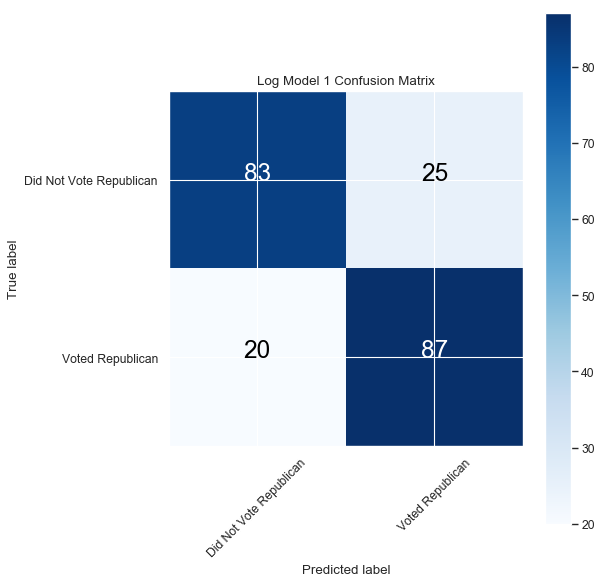

In [27]:
#Plot the confusion matrix
plot_confusion_matrix(confusion_log_model_1,
                          normalize=False,
                          title='Log Model 1 Confusion Matrix',
                          cmap=plt.cm.Blues)

## 6. Initial Regression - With Feature Engineering

In [28]:
#This is an initial logistic regression of all dependent variables using Scikit learn
#using the dataframe with feature engineering

#Split data to be used in the models between the target variable and features

# X will take every dependent variable but the target and other index variables
X_log_model_2 = election_df_feature_engineering.drop(['Target_Presidential_R_bool','CD_Id_Year', 'District_Name','State'], axis = 1) 

# Create target variable
y_log_model_2 = election_df_feature_engineering['Target_Presidential_R_bool'] # y is the column we're trying to predict

In [29]:
#Split the data into a train and test set
X_train_log_model_2, X_test_log_model_2, y_train_log_model_2, y_test_log_model_2 = train_test_split(X_log_model_2, y_log_model_2, random_state=1)


sc_log_model_2=StandardScaler()
X_train_scaled_log_model_2 = sc_log_model_2.fit_transform(X_train_log_model_2)
X_test_scaled_log_model_2 = sc_log_model_2.transform(X_test_log_model_2)


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys


In [30]:
#Fit the model and view the coefficients
log_model_2 = LogisticRegression(C=1e9)
log_model_2.fit(X_train_scaled_log_model_2, y_train_log_model_2)
zip(X_train_log_model_2.columns, log_model_2.coef_[0])
log_model_2.coef_

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[ 0.3249525 ,  0.32968353, -0.32968353, -1.2394802 , -0.06744   ,
         1.66203258,  0.6646211 ,  0.16236504,  0.11924738, -1.790123  ,
         0.37605963, -0.11135102, -0.90754181,  5.79804716, -1.84690123,
         7.19502199, -0.93415111,  0.74969558, -0.77582211, -0.4703349 ,
         0.41626362,  1.28900054, -0.03341913, -0.54523342,  1.05981702,
         1.50937685, -0.07407493,  1.52140038,  0.90304894, -0.90304894,
        -0.47081946, -3.32974849, -0.23986604,  0.04503242, -0.09499389,
         0.64467386, -0.48384564,  0.0859097 , -0.32243695, -0.2723757 ,
         0.23263825, -0.42372671]])

In [31]:
#Makes predictions on the train and test set
y_pred_class_log_model_2_train = log_model_2.predict(X_train_scaled_log_model_2)


#Calculate the model's accuracy and f1 score
print("The training accuracy is: ", metrics.accuracy_score(y_train_log_model_2, y_pred_class_log_model_2_train))

print("The training f1 score is: ", metrics.f1_score(y_train_log_model_2, y_pred_class_log_model_2_train))

The training accuracy is:  0.8728682170542635
The training f1 score is:  0.881159420289855


In [32]:
#Class predictions on the test set (not predicted probabilities)
y_pred_class_log_model_2 = log_model_2.predict(X_test_scaled_log_model_2)

#Calculate the model's accuracy and f1 score
print("The testing accuracy is: ", metrics.accuracy_score(y_test_log_model_2, y_pred_class_log_model_2))

print("The testing f1 score is: ", metrics.f1_score(y_test_log_model_2, y_pred_class_log_model_2))

The testing accuracy is:  0.8325581395348837
The testing f1 score is:  0.8348623853211008


In [33]:
#Save confusion matrix and slice into four pieces
confusion_log_model_2 = metrics.confusion_matrix(y_test_log_model_2, y_pred_class_log_model_2)
TP_log_model_2 = confusion_log_model_1[1][1]
TN_log_model_2 = confusion_log_model_1[0][0]
FP_log_model_2 = confusion_log_model_1[0][1]
FN_log_model_2 = confusion_log_model_1[1][0]

print('Log Model 2 Confusion Matrix:')
print ('True Positives:', TP_log_model_2)
print ('True Negatives:', TN_log_model_2)
print ('False Positives:', FP_log_model_2)
print ('False Negatives:', FN_log_model_2)

Log Model 2 Confusion Matrix:
True Positives: 87
True Negatives: 83
False Positives: 25
False Negatives: 20


Confusion Matrix, without normalization


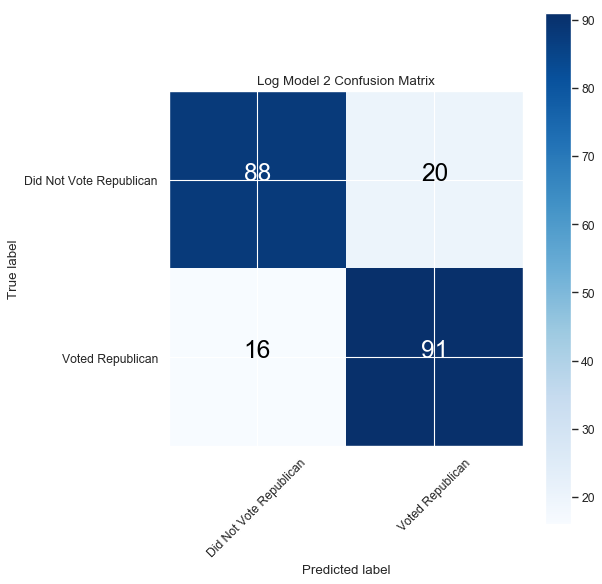

In [34]:
#Plot the confusion Matrix
plot_confusion_matrix(confusion_log_model_2,
                          normalize=False,
                          title='Log Model 2 Confusion Matrix',
                          cmap=plt.cm.Blues)

## 7. Logstic Model Grid Search

In [35]:
#The following is a function that resets the data for future use
def reset_data(df_to_use = None):
    
    if df_to_use == 'engineered':
        
        df = election_df_feature_engineering
        
        features_list = ['Total_Pop', 'Total_Males',
                         'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People',
                         'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian',
                         'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin',
                         'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US',
                         'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income',
                         'Median_Household_Income', 'Below_Poverty_Level_LTM',
                         'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool',
                         'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree',
                         'Total_Married_Households', 'Total_Veterans',
                         'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed',
                         'Median_Age_Of_Worker', 'Total_Workers', 'Ten_Percent_Manufacturing',
                         'Ten_Percent_Agricult', 'Ten_Percent_Construction',
                         'Ten_Percent_Retail', 'Ten_Percent_Transportation',
                         'Ten_Percent_Finance', 'Ten_Percent_Education', 'Ten_Percent_Health',
                         'Ten_Percent_Food', 'Median_Gross_Rent']
    else:
        
        df = election_df
        
        features_list = ['Total_Pop', 'Total_Males',
                         'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People',
                         'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian',
                         'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin', 'Total_Cuban_Origin',
                         'Total_Dominican_Origin', 'Total_Native_US', 'Total_Non_Citizens',
                         'Total_Foreign_Born', 'Median_Income', 'Median_Household_Income',
                         'Below_Poverty_Level_LTM', 'Total_Wealthy_Households', 'Gini_Index',
                         'Total_Less_Highschool', 'Total_Bachelor_Holders', 'Total_STEM',
                         'Total_Business_Degree', 'Total_Married_Households', 'Total_Veterans',
                         'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed',
                         'Median_Age_Of_Worker', 'Total_Workers', 'Total_Working_Agricult',
                         'Total_Working_Construction', 'Total_Working_Manufacturing',
                         'Total_Working_Retail', 'Total_Working_Transportation',
                         'Total_Working_Information', 'Total_Working_Finance', 
                         'Total_Working_Education', 'Total_Working_Health', 'Total_Working_Food',
                         'Total_Working_Public_Admin', 'Median_Gross_Rent']
    
    y = df.Target_Presidential_R_bool
    X = df[features_list]
    
    return train_test_split(X, y, random_state=1, test_size = 0.2)


In [36]:
#Splits the data for the logistic model gridsearch, using the standard features
X_train_log_model_3, X_test_log_model_3, y_train_log_model_3, y_test_log_model_3 =  reset_data()

sc_log_model_3=StandardScaler()
X_train_scaled_log_model_3= sc_log_model_3.fit_transform(X_train_log_model_3)
X_test_scaled_log_model_3 = sc_log_model_3.transform(X_test_log_model_3)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [37]:
# Creates logistic regression model
log_model_3 = linear_model.LogisticRegression()

In [38]:
# Creates regularization penalty parameters
penalty = ['l1', 'l2']

# Creates regularization hyperparameters
C = C_param_range = [0.001,0.01,0.1, 0.5, 1, 2, 5, 10]

# Creates hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [39]:
# Creates a grid search using 5-fold cross validation
clf_gs_log_model_3 = GridSearchCV(log_model_3, hyperparameters, cv=5, scoring= "f1") 

In [40]:
# Fits grid search to the training data
log_model_3 = clf_gs_log_model_3.fit(X_train_scaled_log_model_3, y_train_log_model_3) 

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

In [41]:
# View best hyperparameters
print('Best Penalty:', log_model_3.best_estimator_.get_params()['penalty'])
print('Best C:', log_model_3.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 0.5


In [42]:
#Make predictions for scoring purposes
y_pred_train_log_model_3 = log_model_3.best_estimator_.predict(X_train_scaled_log_model_3)

y_pred_test_log_model_3 = log_model_3.best_estimator_.predict(X_test_scaled_log_model_3)

# Model accuracy and f1 scores
print("Training Accuracy for Log Model 3 (GS Standard Features):", metrics.accuracy_score(y_train_log_model_3, y_pred_train_log_model_3))
print("Training F1 Score for Log Model 3 (GS Standard Features):", metrics.f1_score(y_train_log_model_3, y_pred_train_log_model_3))
print("")
print("Testing Accuracy for Log Model 3 (GS Standard Features):", metrics.accuracy_score(y_test_log_model_3, y_pred_test_log_model_3))
print("Testing F1 Score for Log Model 3 (GS Standard Features):", metrics.f1_score(y_test_log_model_3, y_pred_test_log_model_3))

Training Accuracy for Log Model 3 (GS Standard Features): 0.8531976744186046
Training F1 Score for Log Model 3 (GS Standard Features): 0.8603042876901796

Testing Accuracy for Log Model 3 (GS Standard Features): 0.8255813953488372
Testing F1 Score for Log Model 3 (GS Standard Features): 0.8333333333333333


In [43]:
# Sorts feature importances in descending order and displays the top 10

model_params_log_model_3 = list(zip(list(X_train_log_model_3.columns), log_model_3.best_estimator_.coef_[0]))

model_params_log_model_3.sort(key = lambda x: abs(x[1]), reverse=True)
model_params_log_model_3[:10]

[('Total_Mexican_Origin', -1.2545620963427992),
 ('Total_Married_Households', 1.2221220346188741),
 ('Total_Non_Citizens', -0.8750838500781049),
 ('Total_Less_Highschool', 0.7684266721367601),
 ('Below_Poverty_Level_LTM', -0.7166345888523232),
 ('Median_Age', -0.6444965230588454),
 ('Total_Business_Degree', 0.6431773545860956),
 ('Total_Workers', -0.5867065041493248),
 ('Total_White_People', 0.5605517673903814),
 ('Median_Income', -0.5047173948391971)]

<Figure size 432x288 with 0 Axes>

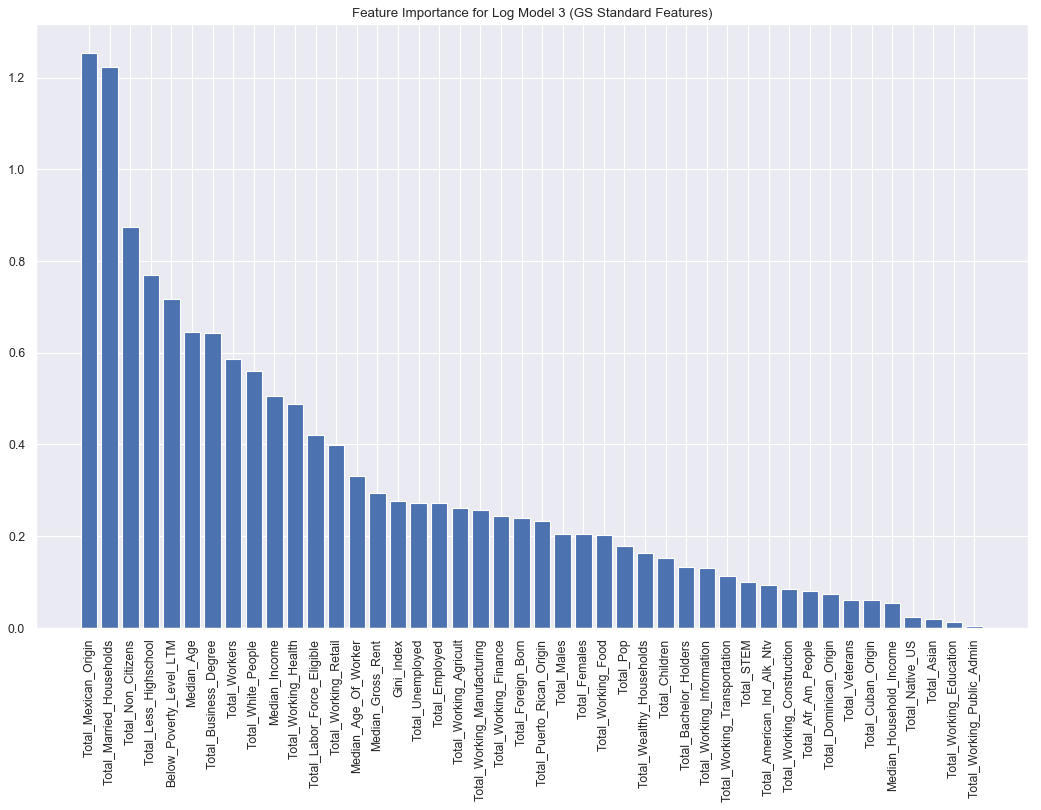

In [44]:
#Plots the parameter importance

# Rearrange feature names so they match the sorted feature importances
model_features_log_model_3 = [i[0] for i in model_params_log_model_3]

feature_weights_log_model_3 = [abs(i[1]) for i in model_params_log_model_3]

# Creates the plot

plt.figure()
figure(figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
# Creates the plot title
plt.title("Feature Importance for Log Model 3 (GS Standard Features)")

# Add bars
plt.bar(model_features_log_model_3, feature_weights_log_model_3)

# Add feature names as x-axis labels
plt.xticks(rotation=90)

# Show plot
plt.show()

In [45]:
# View confusion matrix and slice into four pieces

confusion_log_model_3 = metrics.confusion_matrix(y_test_log_model_3, y_pred_test_log_model_3)
TP_log_model_3 = confusion_log_model_3[1][1]
TN_log_model_3 = confusion_log_model_3[0][0]
FP_log_model_3 = confusion_log_model_3[0][1]
FN_log_model_3 = confusion_log_model_3[1][0]

print('Log Model 3 Confusion Matrix:')
print ('True Positives:', TP_log_model_3)
print ('True Negatives:', TN_log_model_3)
print ('False Positives:', FP_log_model_3)
print ('False Negatives:', FN_log_model_3)

Log Model 3 Confusion Matrix:
True Positives: 75
True Negatives: 67
False Positives: 13
False Negatives: 17


Confusion Matrix, without normalization


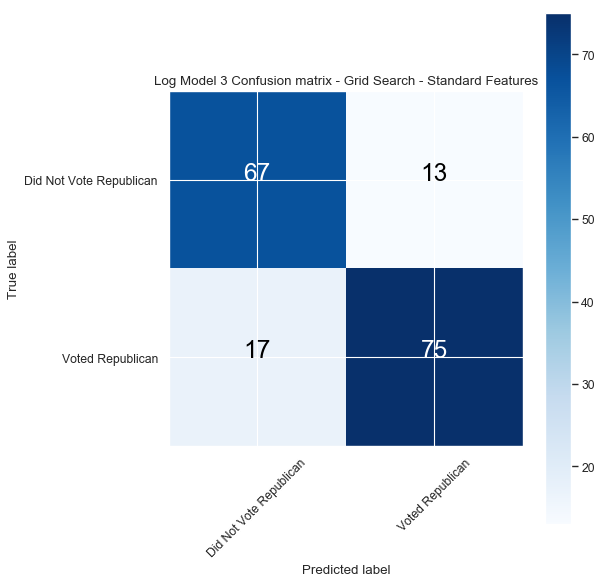

In [46]:
#Plots the confusion matrix visualization
confusion_log_model_3 = metrics.confusion_matrix(y_test_log_model_3, y_pred_test_log_model_3)

plot_confusion_matrix(confusion_log_model_3, title='Log Model 3 Confusion matrix - Grid Search - Standard Features')


## 8. Logistic Model Grid Search With Engineered Features

In [47]:
#Splits the data for the logistic model gridsearch, using the engineered features
X_train_log_model_4, X_test_log_model_4, y_train_log_model_4, y_test_log_model_4 =  reset_data('engineered')

sc_log_model_4=StandardScaler()
X_train_scaled_log_model_4= sc_log_model_4.fit_transform(X_train_log_model_4)
X_test_scaled_log_model_4 = sc_log_model_4.transform(X_test_log_model_4)

# Create logistic regression model
log_model_4 = linear_model.LogisticRegression()

# Create grid search using 5-fold cross validation, same parameters as before
clf_gs_log_model_4 = GridSearchCV(log_model_4, hyperparameters, cv=5, scoring= "f1") 

# Fit grid search
log_model_4 = clf_gs_log_model_4.fit(X_train_scaled_log_model_4, y_train_log_model_4)



/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision',

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [48]:
# View best hyperparameters
print('Best Penalty:', log_model_4.best_estimator_.get_params()['penalty'])
print('Best C:', log_model_4.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 0.1


In [49]:
#Make predictions for scoring purposes

y_pred_train_log_model_4 = log_model_4.best_estimator_.predict(X_train_scaled_log_model_4)

y_pred_test_log_model_4 = log_model_4.best_estimator_.predict(X_test_scaled_log_model_4)

# Model accuracy and f1 scores
print("Training Accuracy for Log Model 4 (GS Engineered Features):", metrics.accuracy_score(y_train_log_model_4, y_pred_train_log_model_4))
print("Training F1 Score for Log Model 4 (GS Engineered Features):", metrics.f1_score(y_train_log_model_4, y_pred_train_log_model_4))
print("")
print("Testing Accuracy for Log Model 4 (GS Engineered Features):", metrics.accuracy_score(y_test_log_model_4, y_pred_test_log_model_4))
print("Testing F1 Score for Log Model 4 (GS Engineered Features):", metrics.f1_score(y_test_log_model_4, y_pred_test_log_model_4))

Training Accuracy for Log Model 4 (GS Engineered Features): 0.8619186046511628
Training F1 Score for Log Model 4 (GS Engineered Features): 0.8696844993141288

Testing Accuracy for Log Model 4 (GS Engineered Features): 0.8197674418604651
Testing F1 Score for Log Model 4 (GS Engineered Features): 0.835978835978836


In [50]:
# Sorts feature importances in descending order and displays the top 10

model_params_log_model_4 = list(zip(list(X_train_log_model_4.columns), log_model_4.best_estimator_.coef_[0]))

model_params_log_model_4.sort(key = lambda x: abs(x[1]), reverse=True)
model_params_log_model_4[:10]

[('Total_Married_Households', 0.9355359942034567),
 ('Total_Mexican_Origin', -0.7888351021776946),
 ('Total_Business_Degree', 0.38687193733909986),
 ('Below_Poverty_Level_LTM', -0.3829227465497463),
 ('Total_Labor_Force_Eligible', -0.3693111680660716),
 ('Ten_Percent_Retail', 0.3247314402864715),
 ('Total_Non_Citizens', -0.3246307664901136),
 ('Total_Workers', -0.3220279866177509),
 ('Total_White_People', 0.3176435295961666),
 ('Median_Income', -0.3123338017333693)]

<Figure size 432x288 with 0 Axes>

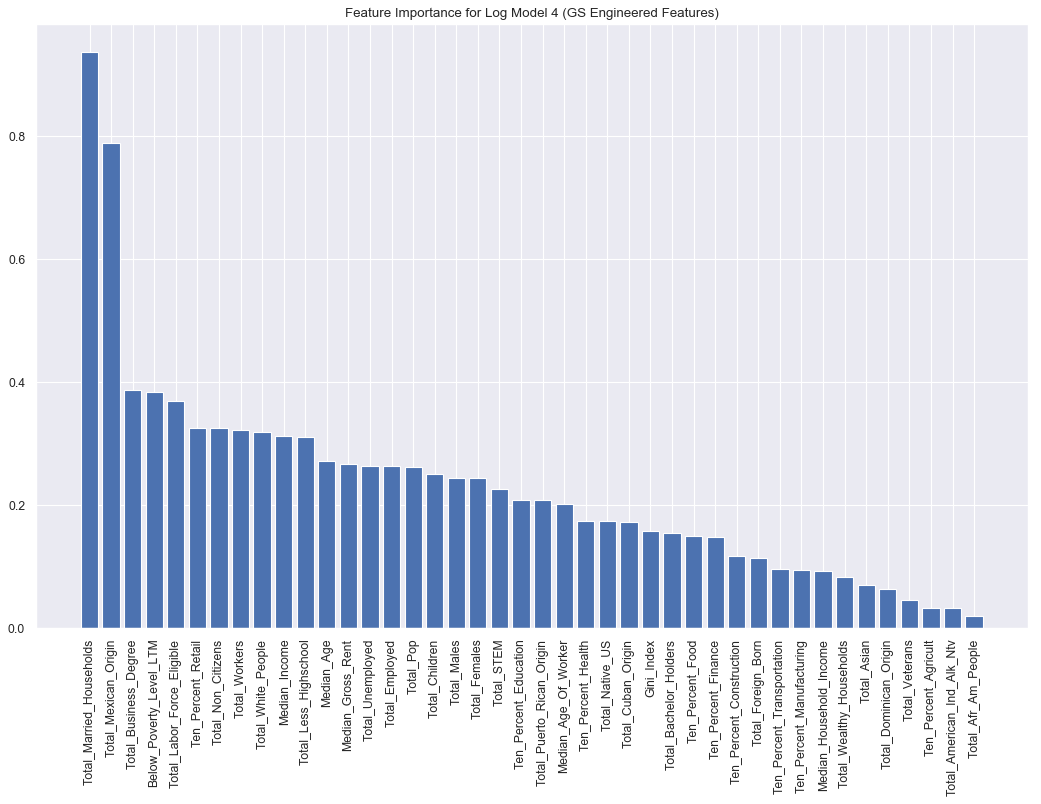

In [51]:
#Plot the parameter importance

# Rearrange feature names so they match the sorted feature importances
model_features_log_model_4 = [i[0] for i in model_params_log_model_4]

feature_weights_log_model_4 = [abs(i[1]) for i in model_params_log_model_4]

# Create plot

plt.figure()
figure(figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
# Create plot title
plt.title("Feature Importance for Log Model 4 (GS Engineered Features)")

# Add bars
plt.bar(model_features_log_model_4, feature_weights_log_model_4)

# Add feature names as x-axis labels
plt.xticks(rotation=90)

# Show plot
plt.show()

Confusion Matrix, without normalization


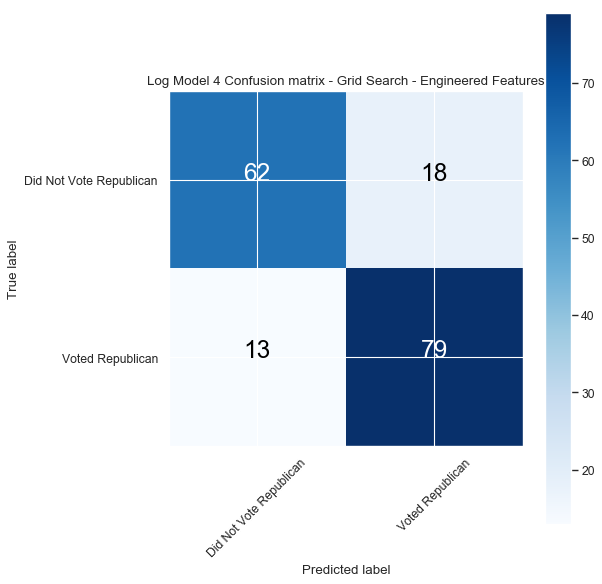

In [52]:
#View the confusion matrix
confusion_log_model_4 = metrics.confusion_matrix(y_test_log_model_4, y_pred_test_log_model_4)
plot_confusion_matrix(confusion_log_model_4, title='Log Model 4 Confusion matrix - Grid Search - Engineered Features')

## 9. Logstic Model Grid Search On The Standard Set- With Polynomials

In [53]:
#Create a pipeline for a polynomial grid search
pipe_lr_poly = Pipeline([('poly', PolynomialFeatures(degree=3)),
            ('scl', StandardScaler()),
            ('clf', LogisticRegression(random_state=42))])

In [54]:
#Sets up the parameters to search through
penalty_param_range_lr_poly = [1.0, 0.5, 0.1, .01]

grid_params_lr_poly = [{'clf__penalty': ['l1', 'l2'], 'clf__C': penalty_param_range_lr_poly, 'clf__solver': ['liblinear']}] 



In [55]:
#Splits the data for the polynomial logistic model gridsearch, using the standard features
X_train_log_model_5, X_test_log_model_5, y_train_log_model_5, y_test_log_model_5 =  reset_data()

sc_log_model_5=StandardScaler()
X_train_scaled_log_model_5= sc_log_model_5.fit_transform(X_train_log_model_5)
X_test_scaled_log_model_5 = sc_log_model_5.transform(X_test_log_model_5)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [56]:
#Fits the model
log_model_5 = GridSearchCV(estimator=pipe_lr_poly, param_grid=grid_params_lr_poly, scoring='f1', cv=10, verbose=5)
log_model_5.fit(X_train_scaled_log_model_5, y_train_log_model_5)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.7692307692307692, total=   1.7s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.8108108108108109, total=   1.6s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s


[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.8000000000000002, total=   1.7s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.3s remaining:    0.0s


[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.8493150684931505, total=   1.6s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.3s remaining:    0.0s


[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.8823529411764706, total=   1.5s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.8732394366197184, total=   1.6s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.8656716417910447, total=   1.8s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.7605633802816902, total=   1.8s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.8831168831168832, total=   1.6s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.8000000000000002, total=   1.6s
[CV] clf__C=1.0, clf__penalty=l2, clf__solver=liblinear .

[CV]  clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, score=0.8169014084507044, total=   6.8s
[CV] clf__C=0.1, clf__penalty=l2, clf__solver=liblinear ..............
[CV]  clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, score=0.8695652173913043, total=   6.6s
[CV] clf__C=0.1, clf__penalty=l2, clf__solver=liblinear ..............
[CV]  clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, score=0.904109589041096, total=   6.5s
[CV] clf__C=0.1, clf__penalty=l2, clf__solver=liblinear ..............
[CV]  clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, score=0.8450704225352113, total=   6.9s
[CV] clf__C=0.1, clf__penalty=l2, clf__solver=liblinear ..............
[CV]  clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, score=0.868421052631579, total=   6.2s
[CV] clf__C=0.1, clf__penalty=l2, clf__solver=liblinear ..............
[CV]  clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, score=0.8533333333333333, total=   6.5s
[CV] clf__C=0.1, clf__penalty=l2, clf__solver=liblinear ...

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  6.2min finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'clf__penalty': ['l1', 'l2'], 'clf__C': [1.0, 0.5, 0.1, 0.01], 'clf__solver': ['liblinear']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=5)

In [57]:
#Loading the saved model with pickle
#log_model_5_pkl = open('./Classification_Models_After_log_model_5.pkl', 'rb')
#log_model_5 = pickle.load(log_model_5_pkl)
#print("Loaded log_model_5 Pickle :: ", log_model_5)

In [58]:
# Best params
print('Best params: %s' % log_model_5.best_params_)
# Best training data accuracy
print('Best training accuracy: %.3f' % log_model_5.best_score_)
# Predict on test data with best params
y_pred_test_log_model_5 = log_model_5.predict(X_test_scaled_log_model_5)
# Test data accuracy of model with best params
print('Test set F1 score for best params: %.4f ' % f1_score(y_test_log_model_5, y_pred_test_log_model_5))

Best params: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best training accuracy: 0.849
Test set F1 score for best params: 0.8087 


In [59]:
#Make predictions for scoring purposes
y_pred_train_log_model_5 = log_model_5.predict(X_train_scaled_log_model_5)

# Model accuracy and f1 scores
print("Training Accuracy for Log Model 5 (GS Polynomials Standard Features):", accuracy_score(y_train_log_model_5, y_pred_train_log_model_5))
print("Training F1 Score for Log Model 5 (GS Polynomials Standard Features):", f1_score(y_train_log_model_5, y_pred_train_log_model_5))
print("")
print("Testing Accuracy for Log Model 5 (GS Polynomials Standard Features):", accuracy_score(y_test_log_model_5, y_pred_test_log_model_5))
print("Testing F1 Score for Log Model 5 (GS Polynomials Standard Features):", f1_score(y_test_log_model_5, y_pred_test_log_model_5))

Training Accuracy for Log Model 5 (GS Polynomials Standard Features): 0.9898255813953488
Training F1 Score for Log Model 5 (GS Polynomials Standard Features): 0.9901547116736991

Testing Accuracy for Log Model 5 (GS Polynomials Standard Features): 0.7965116279069767
Testing F1 Score for Log Model 5 (GS Polynomials Standard Features): 0.8087431693989071


Confusion Matrix, without normalization


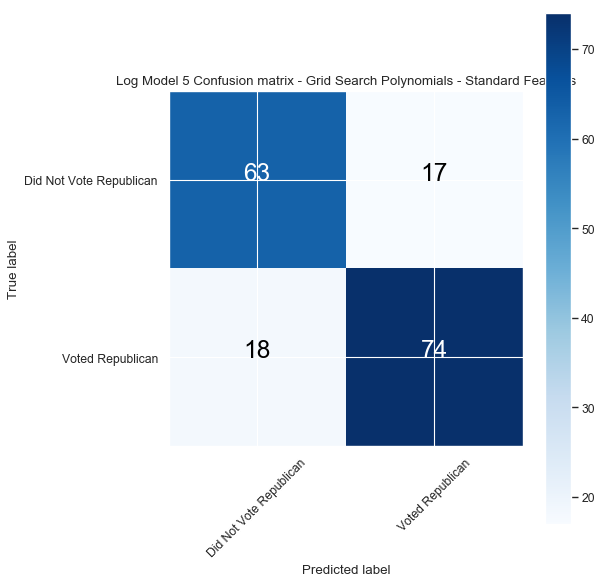

In [60]:
#View the confusion matrix
confusion_log_model_5 = metrics.confusion_matrix(y_test_log_model_5, y_pred_test_log_model_5)
plot_confusion_matrix(confusion_log_model_5, title='Log Model 5 Confusion matrix - Grid Search Polynomials - Standard Features')

In [61]:
#Run this code to save the model data
#make_pickle(log_model_5, 'log_model_5')

## 10. Logstic Model Grid Search On The Engineered Set- With Polynomials

In [62]:
#Splits the data for the polynomial logistic model gridsearch, using the engineered features
X_train_log_model_6, X_test_log_model_6, y_train_log_model_6, y_test_log_model_6 =  reset_data('engineered')

sc_log_model_6=StandardScaler()
X_train_scaled_log_model_6= sc_log_model_6.fit_transform(X_train_log_model_6)
X_test_scaled_log_model_6 = sc_log_model_6.transform(X_test_log_model_6)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [63]:
log_model_6 = GridSearchCV(estimator=pipe_lr_poly, param_grid=grid_params_lr_poly, scoring='f1', cv=10, verbose=5)
log_model_6.fit(X_train_scaled_log_model_6, y_train_log_model_6)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.7714285714285715, total=   1.4s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.8648648648648649, total=   1.3s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s


[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.8, total=   1.5s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.2s remaining:    0.0s


[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.8732394366197184, total=   1.2s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.8s remaining:    0.0s


[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.8169014084507044, total=   1.3s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.8493150684931505, total=   1.3s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.823529411764706, total=   1.5s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.8157894736842105, total=   1.3s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.8732394366197184, total=   1.3s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.8358208955223881, total=   1.3s
[CV] clf__C=1.0, clf__penalty=l2, clf__solver=liblinear ..

[CV]  clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, score=0.8055555555555555, total=   6.4s
[CV] clf__C=0.1, clf__penalty=l2, clf__solver=liblinear ..............
[CV]  clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, score=0.8656716417910447, total=   6.1s
[CV] clf__C=0.1, clf__penalty=l2, clf__solver=liblinear ..............
[CV]  clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, score=0.8266666666666667, total=   5.8s
[CV] clf__C=0.1, clf__penalty=l2, clf__solver=liblinear ..............
[CV]  clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, score=0.8529411764705883, total=   5.4s
[CV] clf__C=0.1, clf__penalty=l2, clf__solver=liblinear ..............
[CV]  clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, score=0.7848101265822784, total=   6.1s
[CV] clf__C=0.1, clf__penalty=l2, clf__solver=liblinear ..............
[CV]  clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, score=0.8611111111111112, total=   5.9s
[CV] clf__C=0.1, clf__penalty=l2, clf__solver=liblinear .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  5.4min finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'clf__penalty': ['l1', 'l2'], 'clf__C': [1.0, 0.5, 0.1, 0.01], 'clf__solver': ['liblinear']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=5)

In [64]:
#Loading the saved polynomial logistic model with pickle
#log_model_6_pkl = open('./Classification_Models_After_log_model_6.pkl', 'rb')
#log_model_6 = pickle.load(log_model_6_pkl)
#print("Loaded log_model_6 Pickle :: ", log_model_6)

In [65]:
# Best params
print('Best params: %s' % log_model_6.best_params_)
# Best training data accuracy
print('Best training accuracy: %.3f' % log_model_5.best_score_)
# Predict on test data with best params
y_pred_test_log_model_6 = log_model_6.predict(X_test_scaled_log_model_6)
# Test data accuracy of model with best params
print('Test set F1 score for best params: %.4f ' % f1_score(y_test_log_model_6, y_pred_test_log_model_6))

Best params: {'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 0.849
Test set F1 score for best params: 0.8000 


In [66]:
#Make predictions for scoring purposes
y_pred_train_log_model_6 = log_model_6.predict(X_train_scaled_log_model_6)

# Prints the accuracy and f1 scores
print("Training Accuracy for Log Model 6 (GS Polynomials Engineered Features):", accuracy_score(y_train_log_model_6, y_pred_train_log_model_6))
print("Training F1 Score for Log Model 6 (GS Polynomials Engineered Features):", f1_score(y_train_log_model_6, y_pred_train_log_model_6))
print("")
print("Testing Accuracy for Log Model 6 (GS Polynomials Engineered Features):", accuracy_score(y_test_log_model_6, y_pred_test_log_model_6))
print("Testing F1 Score for Log Model 6 (GS Polynomials Engineered Features):", f1_score(y_test_log_model_6, y_pred_test_log_model_6))

Training Accuracy for Log Model 6 (GS Polynomials Engineered Features): 0.9026162790697675
Training F1 Score for Log Model 6 (GS Polynomials Engineered Features): 0.908344733242134

Testing Accuracy for Log Model 6 (GS Polynomials Engineered Features): 0.7790697674418605
Testing F1 Score for Log Model 6 (GS Polynomials Engineered Features): 0.8


Confusion Matrix, without normalization


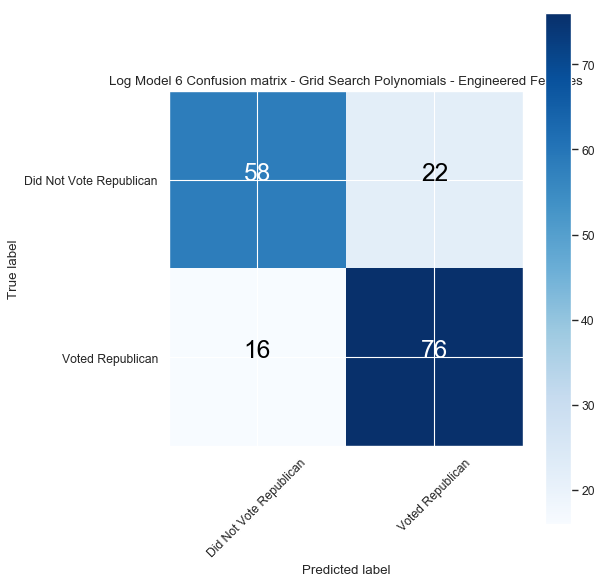

In [67]:
#View the confusion matrix
confusion_log_model_6 = metrics.confusion_matrix(y_test_log_model_6, y_pred_test_log_model_6)
plot_confusion_matrix(confusion_log_model_6, title='Log Model 6 Confusion matrix - Grid Search Polynomials - Engineered Features')

In [68]:
#Run this code to save the model data
#make_pickle(log_model_6, 'log_model_6')

## 11. KNN - Standard Set

In [69]:
#Splits the data for the KNN model gridsearch, using the standard features
X_train_KNN_model_1, X_test_KNN_model_1, y_train_KNN_model_1, y_test_KNN_model_1 =  reset_data()

sc_log_KNN_model_1=StandardScaler()
X_train_scaled_KNN_model_1= sc_log_KNN_model_1.fit_transform(X_train_KNN_model_1)
X_test_scaled_KNN_model_1 = sc_log_KNN_model_1.transform(X_test_KNN_model_1)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [70]:
#Creates a pipeline of parameters for the KNN model
pipe_KNN_poly = Pipeline([('poly', PolynomialFeatures(degree=3)),
            ('scl', StandardScaler()),
            ('knn', KNeighborsClassifier())])

In [71]:
#Creates parameters for the KNN model
neighbors= list(range(1,20,2))
grid_params_KNN = [{'knn__n_neighbors':neighbors, 'knn__weights': ['uniform', 'distance']}] 

In [72]:
#Creates the KNN model
KNN_model_1 = GridSearchCV(estimator=pipe_KNN_poly, param_grid=grid_params_KNN, scoring='f1',
                           cv=5, verbose = 5)

In [73]:
#Fits the KNN model to the data
KNN_model_1.fit(X_train_scaled_KNN_model_1, y_train_KNN_model_1)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] knn__n_neighbors=1, knn__weights=uniform ........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  knn__n_neighbors=1, knn__weights=uniform, score=0.7432432432432432, total=   2.7s
[CV] knn__n_neighbors=1, knn__weights=uniform ........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV]  knn__n_neighbors=1, knn__weights=uniform, score=0.717948717948718, total=   2.8s
[CV] knn__n_neighbors=1, knn__weights=uniform ........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s


[CV]  knn__n_neighbors=1, knn__weights=uniform, score=0.8053691275167785, total=   2.8s
[CV] knn__n_neighbors=1, knn__weights=uniform ........................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.0s remaining:    0.0s


[CV]  knn__n_neighbors=1, knn__weights=uniform, score=0.7338129496402879, total=   2.5s
[CV] knn__n_neighbors=1, knn__weights=uniform ........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   15.7s remaining:    0.0s


[CV]  knn__n_neighbors=1, knn__weights=uniform, score=0.7972972972972971, total=   2.4s
[CV] knn__n_neighbors=1, knn__weights=distance .......................
[CV]  knn__n_neighbors=1, knn__weights=distance, score=0.7432432432432432, total=   2.4s
[CV] knn__n_neighbors=1, knn__weights=distance .......................
[CV]  knn__n_neighbors=1, knn__weights=distance, score=0.717948717948718, total=   2.3s
[CV] knn__n_neighbors=1, knn__weights=distance .......................
[CV]  knn__n_neighbors=1, knn__weights=distance, score=0.8053691275167785, total=   2.3s
[CV] knn__n_neighbors=1, knn__weights=distance .......................
[CV]  knn__n_neighbors=1, knn__weights=distance, score=0.7338129496402879, total=   2.3s
[CV] knn__n_neighbors=1, knn__weights=distance .......................
[CV]  knn__n_neighbors=1, knn__weights=distance, score=0.7972972972972971, total=   2.4s
[CV] knn__n_neighbors=3, knn__weights=uniform ........................
[CV]  knn__n_neighbors=3, knn__weights=uni

[CV]  knn__n_neighbors=11, knn__weights=distance, score=0.7486033519553073, total=   2.3s
[CV] knn__n_neighbors=11, knn__weights=distance ......................
[CV]  knn__n_neighbors=11, knn__weights=distance, score=0.7840909090909091, total=   2.3s
[CV] knn__n_neighbors=11, knn__weights=distance ......................
[CV]  knn__n_neighbors=11, knn__weights=distance, score=0.7837837837837838, total=   2.3s
[CV] knn__n_neighbors=11, knn__weights=distance ......................
[CV]  knn__n_neighbors=11, knn__weights=distance, score=0.7719298245614036, total=   2.3s
[CV] knn__n_neighbors=13, knn__weights=uniform .......................
[CV]  knn__n_neighbors=13, knn__weights=uniform, score=0.7727272727272727, total=   2.3s
[CV] knn__n_neighbors=13, knn__weights=uniform .......................
[CV]  knn__n_neighbors=13, knn__weights=uniform, score=0.7444444444444445, total=   2.3s
[CV] knn__n_neighbors=13, knn__weights=uniform .......................
[CV]  knn__n_neighbors=13, knn__weig

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 13.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19], 'knn__weights': ['uniform', 'distance']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=5)

In [74]:
# Best params
print('Best params: %s' % KNN_model_1.best_params_)
# Best training data accuracy
print('Best training accuracy: %.3f' % KNN_model_1.best_score_)
# Predict on test data with best params
y_pred_test_KNN_model_1 = KNN_model_1.predict(X_test_scaled_KNN_model_1)
# Test data accuracy of model with best params
print('Test set F1 score for best params: %.4f ' % f1_score(y_test_KNN_model_1, y_pred_test_KNN_model_1))

Best params: {'knn__n_neighbors': 7, 'knn__weights': 'distance'}
Best training accuracy: 0.788
Test set F1 score for best params: 0.7736 


In [75]:
# Make predictions for scoring purposes
y_pred_train_KNN_model_1 = KNN_model_1.predict(X_train_scaled_KNN_model_1)

# Prints the accuracy and f1 scores
print("Training Accuracy for KNN Model 1 (Standard Features):", accuracy_score(y_train_KNN_model_1, y_pred_train_KNN_model_1))
print("Training F1 Score for KNN Model 1 (Standard Features):", f1_score(y_train_KNN_model_1, y_pred_train_KNN_model_1))
print("")
print("Testing Accuracy for KNN Model 1 (Standard Features):", accuracy_score(y_test_KNN_model_1, y_pred_test_KNN_model_1))
print("Testing F1 Score for KNN Model 1 (Standard Features):", f1_score(y_test_KNN_model_1, y_pred_test_KNN_model_1))

Training Accuracy for KNN Model 1 (Standard Features): 1.0
Training F1 Score for KNN Model 1 (Standard Features): 1.0

Testing Accuracy for KNN Model 1 (Standard Features): 0.7209302325581395
Testing F1 Score for KNN Model 1 (Standard Features): 0.7735849056603774


Confusion Matrix, without normalization


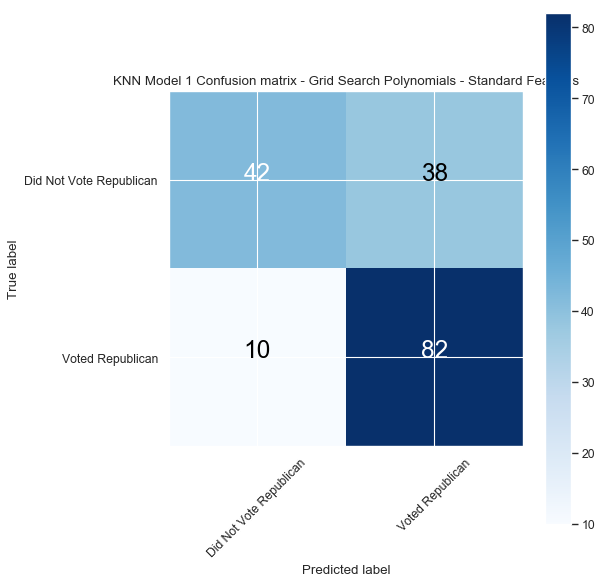

In [76]:
#Plots the confusion matrix
confusion_KNN_model_1 = metrics.confusion_matrix(y_test_KNN_model_1, y_pred_test_KNN_model_1)
plot_confusion_matrix(confusion_KNN_model_1, title='KNN Model 1 Confusion matrix - Grid Search Polynomials - Standard Features')

## 12. KNN - Engineered Features

In [77]:
#Splits the data for the KNN model gridsearch, using the engineered features
X_train_KNN_model_2, X_test_KNN_model_2, y_train_KNN_model_2, y_test_KNN_model_2 =  reset_data('engineered')

sc_log_KNN_model_2=StandardScaler()
X_train_scaled_KNN_model_2= sc_log_KNN_model_2.fit_transform(X_train_KNN_model_2)
X_test_scaled_KNN_model_2 = sc_log_KNN_model_2.transform(X_test_KNN_model_2)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [78]:
#Creates the KNN model
KNN_model_2 = GridSearchCV(estimator=pipe_KNN_poly, param_grid=grid_params_KNN, scoring='f1',
                           cv=5, verbose = 5)

In [79]:
#Fits the KNN model to the data
KNN_model_2.fit(X_train_scaled_KNN_model_2, y_train_KNN_model_2)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] knn__n_neighbors=1, knn__weights=uniform ........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  knn__n_neighbors=1, knn__weights=uniform, score=0.7307692307692307, total=   2.2s
[CV] knn__n_neighbors=1, knn__weights=uniform ........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


[CV]  knn__n_neighbors=1, knn__weights=uniform, score=0.7435897435897436, total=   2.3s
[CV] knn__n_neighbors=1, knn__weights=uniform ........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s


[CV]  knn__n_neighbors=1, knn__weights=uniform, score=0.7631578947368421, total=   2.3s
[CV] knn__n_neighbors=1, knn__weights=uniform ........................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.9s remaining:    0.0s


[CV]  knn__n_neighbors=1, knn__weights=uniform, score=0.7631578947368421, total=   2.0s
[CV] knn__n_neighbors=1, knn__weights=uniform ........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.8s remaining:    0.0s


[CV]  knn__n_neighbors=1, knn__weights=uniform, score=0.778523489932886, total=   2.0s
[CV] knn__n_neighbors=1, knn__weights=distance .......................
[CV]  knn__n_neighbors=1, knn__weights=distance, score=0.7307692307692307, total=   2.0s
[CV] knn__n_neighbors=1, knn__weights=distance .......................
[CV]  knn__n_neighbors=1, knn__weights=distance, score=0.7435897435897436, total=   1.9s
[CV] knn__n_neighbors=1, knn__weights=distance .......................
[CV]  knn__n_neighbors=1, knn__weights=distance, score=0.7631578947368421, total=   1.9s
[CV] knn__n_neighbors=1, knn__weights=distance .......................
[CV]  knn__n_neighbors=1, knn__weights=distance, score=0.7631578947368421, total=   2.0s
[CV] knn__n_neighbors=1, knn__weights=distance .......................
[CV]  knn__n_neighbors=1, knn__weights=distance, score=0.778523489932886, total=   2.1s
[CV] knn__n_neighbors=3, knn__weights=uniform ........................
[CV]  knn__n_neighbors=3, knn__weights=unif

[CV]  knn__n_neighbors=11, knn__weights=distance, score=0.735632183908046, total=   2.2s
[CV] knn__n_neighbors=11, knn__weights=distance ......................
[CV]  knn__n_neighbors=11, knn__weights=distance, score=0.8187919463087248, total=   2.2s
[CV] knn__n_neighbors=11, knn__weights=distance ......................
[CV]  knn__n_neighbors=11, knn__weights=distance, score=0.8235294117647058, total=   2.0s
[CV] knn__n_neighbors=11, knn__weights=distance ......................
[CV]  knn__n_neighbors=11, knn__weights=distance, score=0.742857142857143, total=   2.2s
[CV] knn__n_neighbors=13, knn__weights=uniform .......................
[CV]  knn__n_neighbors=13, knn__weights=uniform, score=0.8170731707317074, total=   2.2s
[CV] knn__n_neighbors=13, knn__weights=uniform .......................
[CV]  knn__n_neighbors=13, knn__weights=uniform, score=0.7241379310344828, total=   2.2s
[CV] knn__n_neighbors=13, knn__weights=uniform .......................
[CV]  knn__n_neighbors=13, knn__weight

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 13.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19], 'knn__weights': ['uniform', 'distance']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=5)

In [80]:
# Best params
print('Best params: %s' % KNN_model_2.best_params_)
# Best training data accuracy
print('Best training accuracy: %.3f' % KNN_model_2.best_score_)
# Predict on test data with best params
y_pred_test_KNN_model_2 = KNN_model_2.predict(X_test_scaled_KNN_model_2)
# Test data accuracy of model with best params
print('Test set F1 score for best params: %.4f ' % f1_score(y_test_KNN_model_2, y_pred_test_KNN_model_2))

Best params: {'knn__n_neighbors': 5, 'knn__weights': 'uniform'}
Best training accuracy: 0.790
Test set F1 score for best params: 0.7805 


In [81]:
# Make predictions for scoring purposes
y_pred_train_KNN_model_2 = KNN_model_2.predict(X_train_scaled_KNN_model_2)

# Prints the accuracy and f1 scores
print("Training Accuracy for KNN Model 2 (Engineered Features):", accuracy_score(y_train_KNN_model_2, y_pred_train_KNN_model_2))
print("Training F1 Score for KNN Model 2 (Engineered Features):", f1_score(y_train_KNN_model_2, y_pred_train_KNN_model_2))
print("")
print("Testing Accuracy for KNN Model 2 (Engineered Features):", accuracy_score(y_test_KNN_model_2, y_pred_test_KNN_model_2))
print("Testing F1 Score for KNN Model 2 (Engineered Features):", f1_score(y_test_KNN_model_2, y_pred_test_KNN_model_2))

Training Accuracy for KNN Model 2 (Engineered Features): 0.8313953488372093
Training F1 Score for KNN Model 2 (Engineered Features): 0.8512820512820513

Testing Accuracy for KNN Model 2 (Engineered Features): 0.7383720930232558
Testing F1 Score for KNN Model 2 (Engineered Features): 0.7804878048780486


Confusion Matrix, without normalization


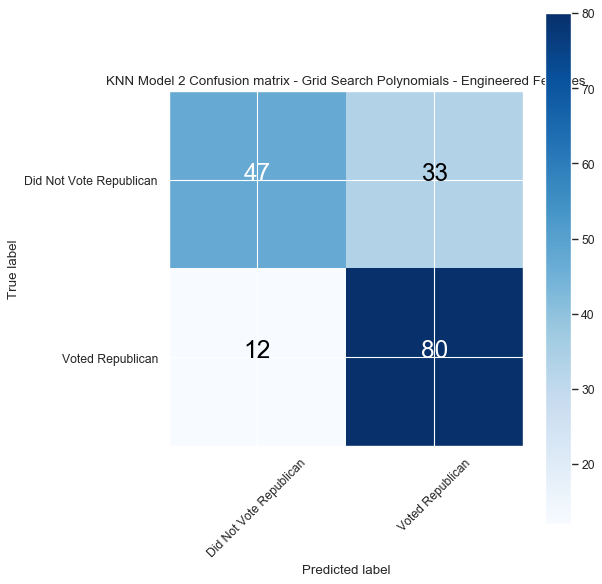

In [82]:
#Plots the confusin matrix
confusion_KNN_model_2 = metrics.confusion_matrix(y_test_KNN_model_2, y_pred_test_KNN_model_2)
plot_confusion_matrix(confusion_KNN_model_2, title='KNN Model 2 Confusion matrix - Grid Search Polynomials - Engineered Features')

## 13. A Function to Visualize Decision Trees

In [83]:
def plot_decision_tree(clf, feature_cols, class_titles, file_name):
    dot_data = StringIO()
    export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols, class_names = class_titles)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    
    
    graph.write_png(file_name + '.png')
    
    return Image(graph.create_png())

## 14. Decision Trees - Standard Set

In [84]:
#Splits the data for the decision tree model using the standard features
X_train_DT_model_1, X_test_DT_model_1, y_train_DT_model_1, y_test_DT_model_1 =  reset_data()

sc_DT_model_1=StandardScaler()
X_train_scaled_DT_model_1= sc_DT_model_1.fit_transform(X_train_DT_model_1)
X_test_scaled_DT_model_1 = sc_DT_model_1.transform(X_test_DT_model_1)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [85]:
# Create Decision Tree classifer object
DT_model_1 = DecisionTreeClassifier()
# Train Decision Tree Classifer
DT_model_1 = DT_model_1.fit(X_train_scaled_DT_model_1, y_train_DT_model_1)

In [86]:
# Predict on training data with best params
y_pred_train_DT_model_1 = DT_model_1.predict(X_train_scaled_DT_model_1)

#Predict the response for test dataset
y_pred_test_DT_model_1 = DT_model_1.predict(X_test_scaled_DT_model_1)

# Prints the accuracy and f1 scores
print("Training Accuracy for Decision Tree Model 1 (Standard Features):", accuracy_score(y_train_DT_model_1, y_pred_train_DT_model_1))
print("Training F1 Score for Decision Tree Model 1 (Standard Features):", f1_score(y_train_DT_model_1, y_pred_train_DT_model_1))
print("")
print("Testing Accuracy for Decision Tree Model 1 (Standard Features):", accuracy_score(y_test_DT_model_1, y_pred_test_DT_model_1))
print("Testing F1 Score for Decision Tree Model 1 (Standard Features):", f1_score(y_test_DT_model_1, y_pred_test_DT_model_1))

Training Accuracy for Decision Tree Model 1 (Standard Features): 1.0
Training F1 Score for Decision Tree Model 1 (Standard Features): 1.0

Testing Accuracy for Decision Tree Model 1 (Standard Features): 0.7441860465116279
Testing F1 Score for Decision Tree Model 1 (Standard Features): 0.7684210526315789


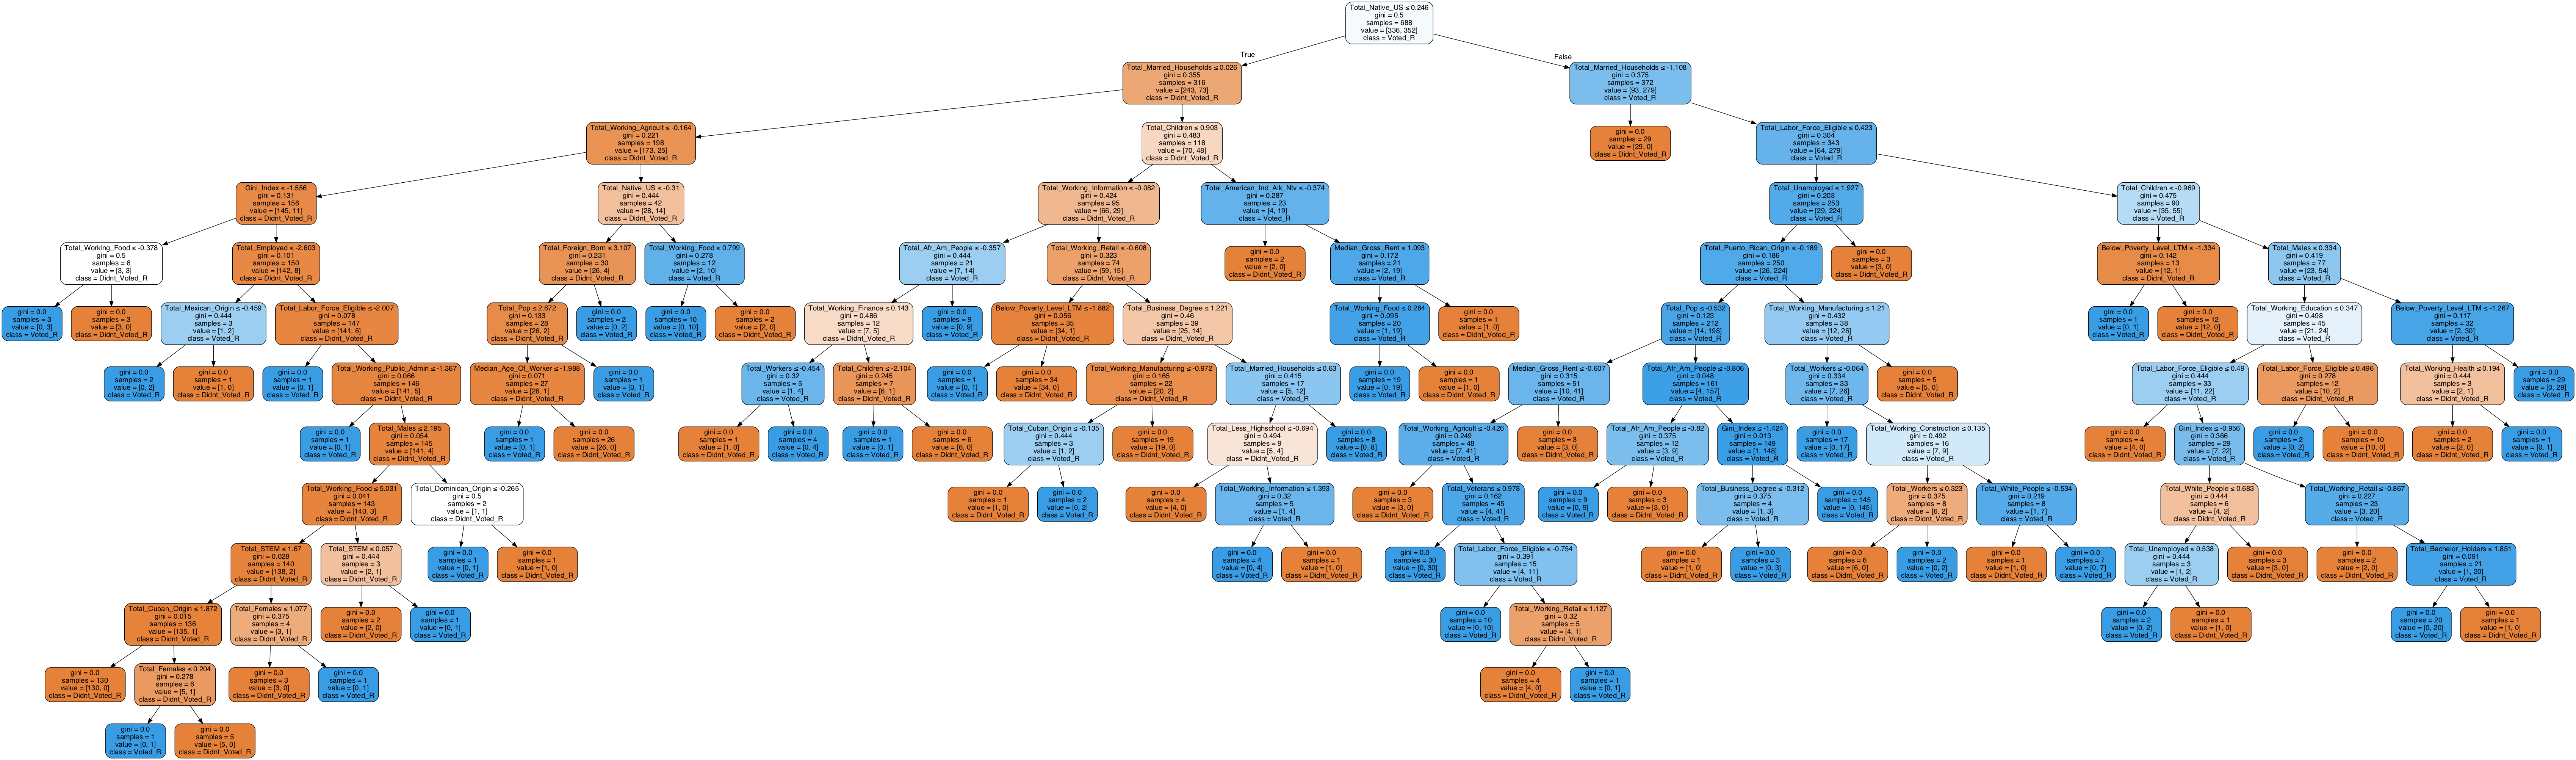

In [87]:
plot_decision_tree(DT_model_1, list(X_train_DT_model_1.columns), ['Didnt_Voted_R', 'Voted_R'], 'DT_model_1')

## 14. Decision Trees - Engineered Set


In [88]:
#Splits the data for the decision tree model using the engineered features
X_train_DT_model_2, X_test_DT_model_2, y_train_DT_model_2, y_test_DT_model_2 =  reset_data('engineered')

sc_DT_model_2=StandardScaler()
X_train_scaled_DT_model_2= sc_DT_model_2.fit_transform(X_train_DT_model_2)
X_test_scaled_DT_model_2 = sc_DT_model_2.transform(X_test_DT_model_2)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [89]:
# Create Decision Tree classifer object
DT_model_2 = DecisionTreeClassifier()
# Train Decision Tree Classifer
DT_model_2 = DT_model_2.fit(X_train_scaled_DT_model_2, y_train_DT_model_2)

In [90]:
# Predict on training data with best params
y_pred_train_DT_model_2 = DT_model_2.predict(X_train_scaled_DT_model_2)

#Predict the response for test dataset
y_pred_test_DT_model_2 = DT_model_2.predict(X_test_scaled_DT_model_2)

# Prints the accuracy and f1 scores
print("Training Accuracy for Decision Tree Model 2 (Engineered Features):", accuracy_score(y_train_DT_model_2, y_pred_train_DT_model_2))
print("Training F1 Score for Decision Tree Model 2 (Engineered Features):", f1_score(y_train_DT_model_2, y_pred_train_DT_model_2))
print("")
print("Testing Accuracy for Decision Tree Model 2 (Engineered Features):", accuracy_score(y_test_DT_model_2, y_pred_test_DT_model_2))
print("Testing F1 Score for Decision Tree Model 2 (Engineered Features):", f1_score(y_test_DT_model_2, y_pred_test_DT_model_2))

Training Accuracy for Decision Tree Model 2 (Engineered Features): 1.0
Training F1 Score for Decision Tree Model 2 (Engineered Features): 1.0

Testing Accuracy for Decision Tree Model 2 (Engineered Features): 0.7616279069767442
Testing F1 Score for Decision Tree Model 2 (Engineered Features): 0.7897435897435897


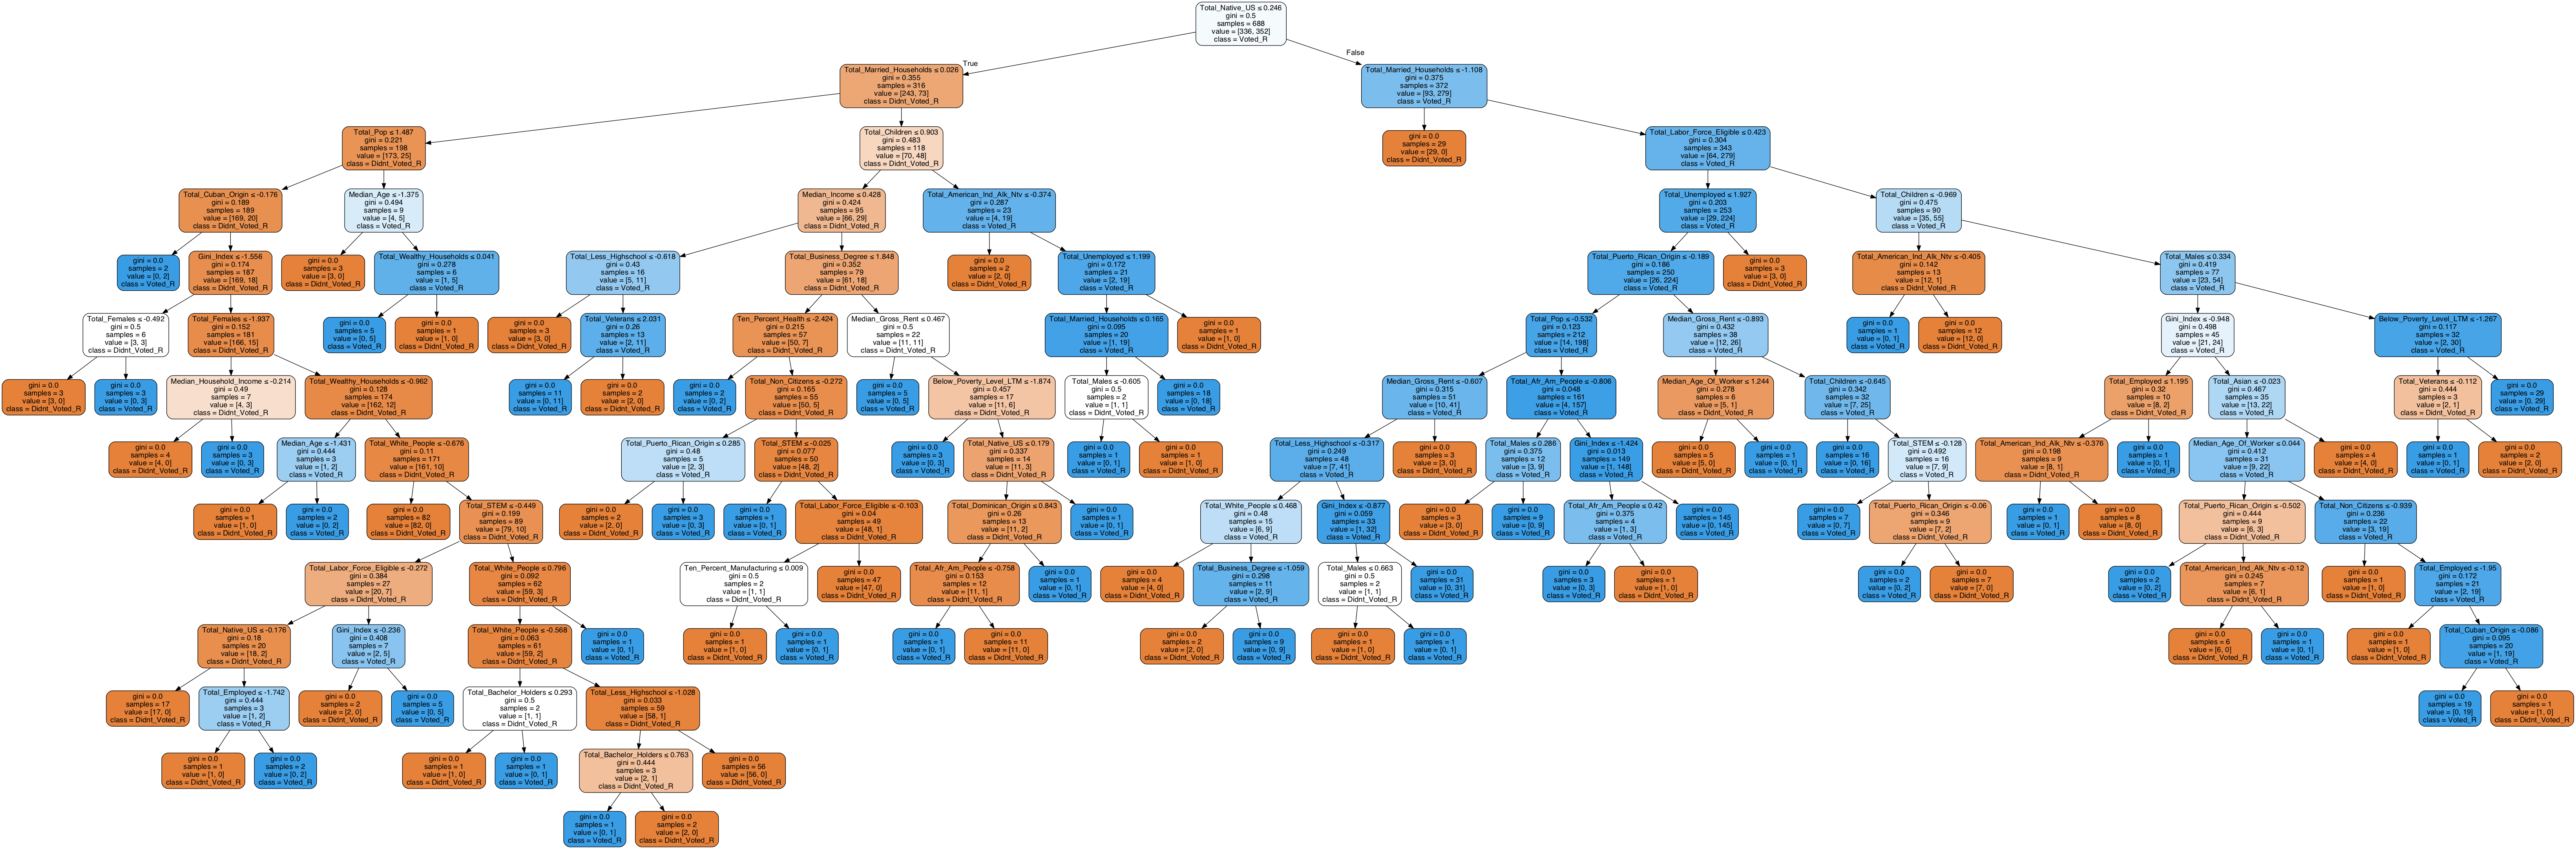

In [91]:
plot_decision_tree(DT_model_2, list(X_train_DT_model_2.columns), ['Didnt_Voted_R', 'Voted_R'], 'DT_model_2')

## 15. Decision Trees - Grid Search - Standard Set

In [92]:
#Splits the data for the decision tree model gridsearch, using the standard features
X_train_DT_model_3, X_test_DT_model_3, y_train_DT_model_3, y_test_DT_model_3 =  reset_data()

sc_DT_model_3=StandardScaler()
X_train_scaled_DT_model_3= sc_DT_model_3.fit_transform(X_train_DT_model_3)
X_test_scaled_DT_model_3 = sc_DT_model_3.transform(X_test_DT_model_3)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [93]:
# The scorers used in the gridsearch to find the best parameters
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

In [94]:
#Parameters and model creation
parameters ={'criterion': ['gini','entropy'], 'min_samples_leaf' : range(5,100,15), 'max_depth': range(2,20,1)}

DT_model_3 = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid= parameters,
                  scoring=scoring, cv=5, refit='AUC', return_train_score=True, verbose = 5)


In [95]:
DT_model_3.fit(X_train_scaled_DT_model_3, y_train_DT_model_3)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=5, AUC=0.7688483844241922, Accuracy=0.762589928057554, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=5, AUC=0.7790624343073366, Accuracy=0.7681159420289855, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=5, AUC=0.8216417910447762, Accuracy=0.8029197080291971, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=5, AUC=0.8337953091684436, Accuracy=0.8102189781021898, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=5, AUC=0.812366737739872, Accuracy=0.76642

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=2, min_samples_leaf=65, AUC=0.8256929637526652, Accuracy=0.781021897810219, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=65 ................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=65, AUC=0.8068230277185501, Accuracy=0.7591240875912408, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=80 ................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=80, AUC=0.7876967688483845, Accuracy=0.762589928057554, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=80 ................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=80, AUC=0.7946184570107211, Accuracy=0.7246376811594203, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=80 ................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=80, AUC=0.7889125799573562, Accuracy=0.6934306569343066, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=80 ................
[CV]  criterion=gini, max_depth=

[CV]  criterion=gini, max_depth=3, min_samples_leaf=95, AUC=0.8453091684434968, Accuracy=0.7664233576642335, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=95 ................
[CV]  criterion=gini, max_depth=3, min_samples_leaf=95, AUC=0.809594882729211, Accuracy=0.7299270072992701, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=4, min_samples_leaf=5, AUC=0.835542667771334, Accuracy=0.7841726618705036, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=4, min_samples_leaf=5, AUC=0.7786420012612991, Accuracy=0.7608695652173914, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=4, min_samples_leaf=5, AUC=0.8477611940298508, Accuracy=0.8248175182481752, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=4, 

[CV]  criterion=gini, max_depth=5, min_samples_leaf=65, AUC=0.8216652858326429, Accuracy=0.7769784172661871, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=65 ................
[CV]  criterion=gini, max_depth=5, min_samples_leaf=65, AUC=0.8223670380491908, Accuracy=0.7753623188405797, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=65 ................
[CV]  criterion=gini, max_depth=5, min_samples_leaf=65, AUC=0.8088486140724946, Accuracy=0.708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=65 ................
[CV]  criterion=gini, max_depth=5, min_samples_leaf=65, AUC=0.8428571428571429, Accuracy=0.781021897810219, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=65 ................
[CV]  criterion=gini, max_depth=5, min_samples_leaf=65, AUC=0.8213219616204692, Accuracy=0.7591240875912408, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=80 ................
[CV]  criterion=gini, max_depth=

[CV]  criterion=gini, max_depth=7, min_samples_leaf=20, AUC=0.8245202558635394, Accuracy=0.7883211678832117, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=20 ................
[CV]  criterion=gini, max_depth=7, min_samples_leaf=20, AUC=0.8837953091684435, Accuracy=0.8029197080291971, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=35 ................
[CV]  criterion=gini, max_depth=7, min_samples_leaf=35, AUC=0.804784589892295, Accuracy=0.7194244604316546, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=35 ................
[CV]  criterion=gini, max_depth=7, min_samples_leaf=35, AUC=0.8449653142737019, Accuracy=0.782608695652174, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=35 ................
[CV]  criterion=gini, max_depth=7, min_samples_leaf=35, AUC=0.8388059701492538, Accuracy=0.8248175182481752, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=35 ................
[CV]  criterion=gini, max_depth=

[CV]  criterion=gini, max_depth=8, min_samples_leaf=95, AUC=0.809594882729211, Accuracy=0.7299270072992701, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=9, min_samples_leaf=5, AUC=0.7889395194697598, Accuracy=0.7553956834532374, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=9, min_samples_leaf=5, AUC=0.7747529955854531, Accuracy=0.7391304347826086, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=9, min_samples_leaf=5, AUC=0.8085287846481877, Accuracy=0.7591240875912408, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=9, min_samples_leaf=5, AUC=0.7980810234541578, Accuracy=0.7664233576642335, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=9, 

[CV]  criterion=gini, max_depth=10, min_samples_leaf=50, AUC=0.85863539445629, Accuracy=0.7956204379562044, total=   0.0s
[CV] criterion=gini, max_depth=10, min_samples_leaf=50 ...............
[CV]  criterion=gini, max_depth=10, min_samples_leaf=50, AUC=0.8410447761194031, Accuracy=0.7664233576642335, total=   0.0s
[CV] criterion=gini, max_depth=10, min_samples_leaf=65 ...............
[CV]  criterion=gini, max_depth=10, min_samples_leaf=65, AUC=0.8216652858326429, Accuracy=0.7769784172661871, total=   0.0s
[CV] criterion=gini, max_depth=10, min_samples_leaf=65 ...............
[CV]  criterion=gini, max_depth=10, min_samples_leaf=65, AUC=0.8223670380491908, Accuracy=0.7753623188405797, total=   0.0s
[CV] criterion=gini, max_depth=10, min_samples_leaf=65 ...............
[CV]  criterion=gini, max_depth=10, min_samples_leaf=65, AUC=0.8088486140724946, Accuracy=0.708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=10, min_samples_leaf=65 ...............
[CV]  criterion=gini, max_de

[CV]  criterion=gini, max_depth=12, min_samples_leaf=20, AUC=0.8032311516155758, Accuracy=0.7410071942446043, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=12, min_samples_leaf=20, AUC=0.8208955223880599, Accuracy=0.782608695652174, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=12, min_samples_leaf=20, AUC=0.8555437100213219, Accuracy=0.781021897810219, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=12, min_samples_leaf=20, AUC=0.8245202558635394, Accuracy=0.7883211678832117, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=12, min_samples_leaf=20, AUC=0.8837953091684435, Accuracy=0.8029197080291971, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_d

[CV]  criterion=gini, max_depth=13, min_samples_leaf=80, AUC=0.8175227837613919, Accuracy=0.762589928057554, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_depth=13, min_samples_leaf=80, AUC=0.804078200546563, Accuracy=0.7246376811594203, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_depth=13, min_samples_leaf=80, AUC=0.822814498933902, Accuracy=0.6934306569343066, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_depth=13, min_samples_leaf=80, AUC=0.8286780383795309, Accuracy=0.7518248175182481, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_depth=13, min_samples_leaf=80, AUC=0.8159914712153518, Accuracy=0.7299270072992701, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=95 ...............
[CV]  criterion=gini, max_de

[CV]  criterion=gini, max_depth=15, min_samples_leaf=35, AUC=0.8449653142737019, Accuracy=0.782608695652174, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_depth=15, min_samples_leaf=35, AUC=0.8388059701492538, Accuracy=0.8248175182481752, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_depth=15, min_samples_leaf=35, AUC=0.8466950959488273, Accuracy=0.8029197080291971, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_depth=15, min_samples_leaf=35, AUC=0.8436034115138593, Accuracy=0.781021897810219, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=50 ...............
[CV]  criterion=gini, max_depth=15, min_samples_leaf=50, AUC=0.8228044739022369, Accuracy=0.7697841726618705, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=50 ...............
[CV]  criterion=gini, max_d

[CV]  criterion=gini, max_depth=17, min_samples_leaf=5, AUC=0.7937775909186462, Accuracy=0.7391304347826086, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=5 ................
[CV]  criterion=gini, max_depth=17, min_samples_leaf=5, AUC=0.8157782515991472, Accuracy=0.7591240875912408, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=5 ................
[CV]  criterion=gini, max_depth=17, min_samples_leaf=5, AUC=0.7980810234541578, Accuracy=0.7664233576642335, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=5 ................
[CV]  criterion=gini, max_depth=17, min_samples_leaf=5, AUC=0.8374200426439232, Accuracy=0.8102189781021898, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=17, min_samples_leaf=20, AUC=0.8032311516155758, Accuracy=0.7410071942446043, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_dep

[CV]  criterion=gini, max_depth=18, min_samples_leaf=65, AUC=0.8223670380491908, Accuracy=0.7753623188405797, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_leaf=65 ...............
[CV]  criterion=gini, max_depth=18, min_samples_leaf=65, AUC=0.8088486140724946, Accuracy=0.708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_leaf=65 ...............
[CV]  criterion=gini, max_depth=18, min_samples_leaf=65, AUC=0.8428571428571429, Accuracy=0.781021897810219, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_leaf=65 ...............
[CV]  criterion=gini, max_depth=18, min_samples_leaf=65, AUC=0.8213219616204692, Accuracy=0.7591240875912408, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_depth=18, min_samples_leaf=80, AUC=0.8175227837613919, Accuracy=0.762589928057554, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_de

[CV]  criterion=entropy, max_depth=2, min_samples_leaf=35, AUC=0.7968017057569297, Accuracy=0.8029197080291971, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=35 .............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=35, AUC=0.8305970149253731, Accuracy=0.7956204379562044, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=35 .............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=35, AUC=0.8052238805970149, Accuracy=0.7591240875912408, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=50, AUC=0.7664664457332229, Accuracy=0.7697841726618705, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=50, AUC=0.8136430523439142, Accuracy=0.782608695652174, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=50 .............
[CV]  criterion=

[CV]  criterion=entropy, max_depth=4, min_samples_leaf=5, AUC=0.8108947804473902, Accuracy=0.7338129496402878, total=   0.0s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=5 ..............
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=5, AUC=0.8013453857473197, Accuracy=0.7608695652173914, total=   0.0s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=5 ..............
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=5, AUC=0.8380597014925374, Accuracy=0.781021897810219, total=   0.0s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=5 ..............
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=5, AUC=0.8788912579957356, Accuracy=0.8102189781021898, total=   0.0s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=5 ..............
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=5, AUC=0.8409381663113006, Accuracy=0.7956204379562044, total=   0.0s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=20 .............
[CV]  criterion=entro

[CV]  criterion=entropy, max_depth=5, min_samples_leaf=35, AUC=0.8294324772162385, Accuracy=0.7553956834532374, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=35 .............
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=35, AUC=0.8334034055076729, Accuracy=0.7681159420289855, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=35 .............
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=35, AUC=0.8415778251599147, Accuracy=0.7956204379562044, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=35 .............
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=35, AUC=0.8492537313432836, Accuracy=0.7372262773722628, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=35 .............
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=35, AUC=0.8404051172707889, Accuracy=0.781021897810219, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=50 .............
[CV]  criterion=

[CV]  criterion=entropy, max_depth=6, min_samples_leaf=65, AUC=0.8428571428571429, Accuracy=0.781021897810219, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=65, AUC=0.8213219616204692, Accuracy=0.7591240875912408, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=80 .............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=80, AUC=0.7966031483015742, Accuracy=0.762589928057554, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=80 .............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=80, AUC=0.804078200546563, Accuracy=0.7246376811594203, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=80 .............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=80, AUC=0.8122601279317697, Accuracy=0.7007299270072993, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=80 .............
[CV]  criterion=en

[CV]  criterion=entropy, max_depth=8, min_samples_leaf=5, AUC=0.8170575692963753, Accuracy=0.7518248175182481, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=5 ..............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=5, AUC=0.8394456289978678, Accuracy=0.8102189781021898, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=20, AUC=0.8316072908036454, Accuracy=0.7697841726618705, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=20, AUC=0.8241538784948497, Accuracy=0.782608695652174, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=20, AUC=0.8215351812366738, Accuracy=0.7518248175182481, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=20 .............
[CV]  criterion=en

[CV]  criterion=entropy, max_depth=9, min_samples_leaf=35, AUC=0.8404051172707889, Accuracy=0.781021897810219, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=9, min_samples_leaf=50, AUC=0.8107912178956089, Accuracy=0.7697841726618705, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=9, min_samples_leaf=50, AUC=0.8300399411393735, Accuracy=0.782608695652174, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=9, min_samples_leaf=50, AUC=0.7869936034115139, Accuracy=0.7007299270072993, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=9, min_samples_leaf=50, AUC=0.8593816631130065, Accuracy=0.7956204379562044, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=50 .............
[CV]  criterion=e

[CV]  criterion=entropy, max_depth=10, min_samples_leaf=80, AUC=0.8254797441364605, Accuracy=0.7518248175182481, total=   0.0s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=80 ............
[CV]  criterion=entropy, max_depth=10, min_samples_leaf=80, AUC=0.8159914712153518, Accuracy=0.7299270072992701, total=   0.0s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=95 ............
[CV]  criterion=entropy, max_depth=10, min_samples_leaf=95, AUC=0.8050952775476388, Accuracy=0.7697841726618705, total=   0.0s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=95 ............
[CV]  criterion=entropy, max_depth=10, min_samples_leaf=95, AUC=0.759932730712634, Accuracy=0.7246376811594203, total=   0.0s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=95 ............
[CV]  criterion=entropy, max_depth=10, min_samples_leaf=95, AUC=0.8054371002132196, Accuracy=0.6861313868613139, total=   0.0s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=95 ............
[CV]  crite

[CV]  criterion=entropy, max_depth=12, min_samples_leaf=5, AUC=0.8394456289978678, Accuracy=0.8102189781021898, total=   0.0s
[CV] criterion=entropy, max_depth=12, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=12, min_samples_leaf=20, AUC=0.8316072908036454, Accuracy=0.7697841726618705, total=   0.0s
[CV] criterion=entropy, max_depth=12, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=12, min_samples_leaf=20, AUC=0.8241538784948497, Accuracy=0.782608695652174, total=   0.0s
[CV] criterion=entropy, max_depth=12, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=12, min_samples_leaf=20, AUC=0.8215351812366738, Accuracy=0.7518248175182481, total=   0.0s
[CV] criterion=entropy, max_depth=12, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=12, min_samples_leaf=20, AUC=0.8515991471215352, Accuracy=0.7664233576642335, total=   0.0s
[CV] criterion=entropy, max_depth=12, min_samples_leaf=20 ............
[CV]  criter

[CV]  criterion=entropy, max_depth=13, min_samples_leaf=35, AUC=0.8404051172707889, Accuracy=0.781021897810219, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=50, AUC=0.8107912178956089, Accuracy=0.7697841726618705, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=50, AUC=0.8300399411393735, Accuracy=0.782608695652174, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=50, AUC=0.7869936034115139, Accuracy=0.7007299270072993, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=50, AUC=0.8593816631130065, Accuracy=0.7956204379562044, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=50 ............
[CV]  criter

[CV]  criterion=entropy, max_depth=14, min_samples_leaf=80, AUC=0.7966031483015742, Accuracy=0.762589928057554, total=   0.0s
[CV] criterion=entropy, max_depth=14, min_samples_leaf=80 ............
[CV]  criterion=entropy, max_depth=14, min_samples_leaf=80, AUC=0.804078200546563, Accuracy=0.7246376811594203, total=   0.0s
[CV] criterion=entropy, max_depth=14, min_samples_leaf=80 ............
[CV]  criterion=entropy, max_depth=14, min_samples_leaf=80, AUC=0.8122601279317697, Accuracy=0.7007299270072993, total=   0.0s
[CV] criterion=entropy, max_depth=14, min_samples_leaf=80 ............
[CV]  criterion=entropy, max_depth=14, min_samples_leaf=80, AUC=0.8254797441364605, Accuracy=0.7518248175182481, total=   0.0s
[CV] criterion=entropy, max_depth=14, min_samples_leaf=80 ............
[CV]  criterion=entropy, max_depth=14, min_samples_leaf=80, AUC=0.8159914712153518, Accuracy=0.7299270072992701, total=   0.0s
[CV] criterion=entropy, max_depth=14, min_samples_leaf=95 ............
[CV]  criter

[CV]  criterion=entropy, max_depth=16, min_samples_leaf=5, AUC=0.7892579356737439, Accuracy=0.7463768115942029, total=   0.0s
[CV] criterion=entropy, max_depth=16, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=16, min_samples_leaf=5, AUC=0.8178038379530918, Accuracy=0.781021897810219, total=   0.0s
[CV] criterion=entropy, max_depth=16, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=16, min_samples_leaf=5, AUC=0.8170575692963753, Accuracy=0.7518248175182481, total=   0.0s
[CV] criterion=entropy, max_depth=16, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=16, min_samples_leaf=5, AUC=0.8394456289978678, Accuracy=0.8102189781021898, total=   0.0s
[CV] criterion=entropy, max_depth=16, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=16, min_samples_leaf=20, AUC=0.8316072908036454, Accuracy=0.7697841726618705, total=   0.0s
[CV] criterion=entropy, max_depth=16, min_samples_leaf=20 ............
[CV]  criterion

[CV]  criterion=entropy, max_depth=17, min_samples_leaf=20, AUC=0.8515991471215352, Accuracy=0.7664233576642335, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=20, AUC=0.8691897654584222, Accuracy=0.7956204379562044, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=35, AUC=0.834507042253521, Accuracy=0.7553956834532374, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=35, AUC=0.8287786420012613, Accuracy=0.7681159420289855, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=35, AUC=0.8415778251599147, Accuracy=0.7956204379562044, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=35 ............
[CV]  crite

[CV]  criterion=entropy, max_depth=18, min_samples_leaf=50, AUC=0.8300399411393735, Accuracy=0.782608695652174, total=   0.0s
[CV] criterion=entropy, max_depth=18, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=18, min_samples_leaf=50, AUC=0.7869936034115139, Accuracy=0.7007299270072993, total=   0.0s
[CV] criterion=entropy, max_depth=18, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=18, min_samples_leaf=50, AUC=0.8593816631130065, Accuracy=0.7956204379562044, total=   0.0s
[CV] criterion=entropy, max_depth=18, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=18, min_samples_leaf=50, AUC=0.8410447761194031, Accuracy=0.7664233576642335, total=   0.0s
[CV] criterion=entropy, max_depth=18, min_samples_leaf=65 ............
[CV]  criterion=entropy, max_depth=18, min_samples_leaf=65, AUC=0.8216652858326429, Accuracy=0.7769784172661871, total=   0.0s
[CV] criterion=entropy, max_depth=18, min_samples_leaf=65 ............
[CV]  crite

[CV]  criterion=entropy, max_depth=19, min_samples_leaf=80, AUC=0.8159914712153518, Accuracy=0.7299270072992701, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=95 ............
[CV]  criterion=entropy, max_depth=19, min_samples_leaf=95, AUC=0.8050952775476388, Accuracy=0.7697841726618705, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=95 ............
[CV]  criterion=entropy, max_depth=19, min_samples_leaf=95, AUC=0.759932730712634, Accuracy=0.7246376811594203, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=95 ............
[CV]  criterion=entropy, max_depth=19, min_samples_leaf=95, AUC=0.8054371002132196, Accuracy=0.6861313868613139, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=95 ............
[CV]  criterion=entropy, max_depth=19, min_samples_leaf=95, AUC=0.8465884861407249, Accuracy=0.7664233576642335, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=95 ............
[CV]  crite

[Parallel(n_jobs=1)]: Done 1260 out of 1260 | elapsed:   15.1s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'min_samples_leaf': range(5, 100, 15), 'max_depth': range(2, 20)},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score=True,
       scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)},
       verbose=5)

In [96]:
# Predict on training data with best params
y_pred_train_DT_model_3 = DT_model_3.predict(X_train_scaled_DT_model_3)

#Predict the response for test dataset
y_pred_test_DT_model_3 = DT_model_3.predict(X_test_scaled_DT_model_3)

# Prints the accuracy and f1 scores
print("Training Accuracy for Decision Tree Model 3 GS (Standard Features):", accuracy_score(y_train_DT_model_3, y_pred_train_DT_model_3))
print("Training F1 Score for Decision Tree Model 3 GS (Standard Features):", f1_score(y_train_DT_model_3, y_pred_train_DT_model_3))
print("")
print("Testing Accuracy for Decision Tree Model 3 GS (Standard Features):", accuracy_score(y_test_DT_model_3, y_pred_test_DT_model_3))
print("Testing F1 Score for Decision Tree Model 3 GS (Standard Features):", f1_score(y_test_DT_model_3, y_pred_test_DT_model_3))

Training Accuracy for Decision Tree Model 3 GS (Standard Features): 0.875
Training F1 Score for Decision Tree Model 3 GS (Standard Features): 0.8828337874659401

Testing Accuracy for Decision Tree Model 3 GS (Standard Features): 0.7558139534883721
Testing F1 Score for Decision Tree Model 3 GS (Standard Features): 0.7857142857142858


In [97]:
print('The top score for a decision tree is: ' + str(DT_model_3.best_score_))
print('The parameters for the top performing decision tree is: ' + str(DT_model_3.best_params_))
print('The top performing decision tree is: ')
print(DT_model_3.best_estimator_)

The top score for a decision tree is: 0.8400517030660595
The parameters for the top performing decision tree is: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 20}
The top performing decision tree is: 
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')


In [98]:
DT_model_3.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_criterion', 'param_max_depth', 'param_min_samples_leaf', 'params', 'split0_test_AUC', 'split1_test_AUC', 'split2_test_AUC', 'split3_test_AUC', 'split4_test_AUC', 'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC', 'split0_train_AUC', 'split1_train_AUC', 'split2_train_AUC', 'split3_train_AUC', 'split4_train_AUC', 'mean_train_AUC', 'std_train_AUC', 'split0_test_Accuracy', 'split1_test_Accuracy', 'split2_test_Accuracy', 'split3_test_Accuracy', 'split4_test_Accuracy', 'mean_test_Accuracy', 'std_test_Accuracy', 'rank_test_Accuracy', 'split0_train_Accuracy', 'split1_train_Accuracy', 'split2_train_Accuracy', 'split3_train_Accuracy', 'split4_train_Accuracy', 'mean_train_Accuracy', 'std_train_Accuracy'])

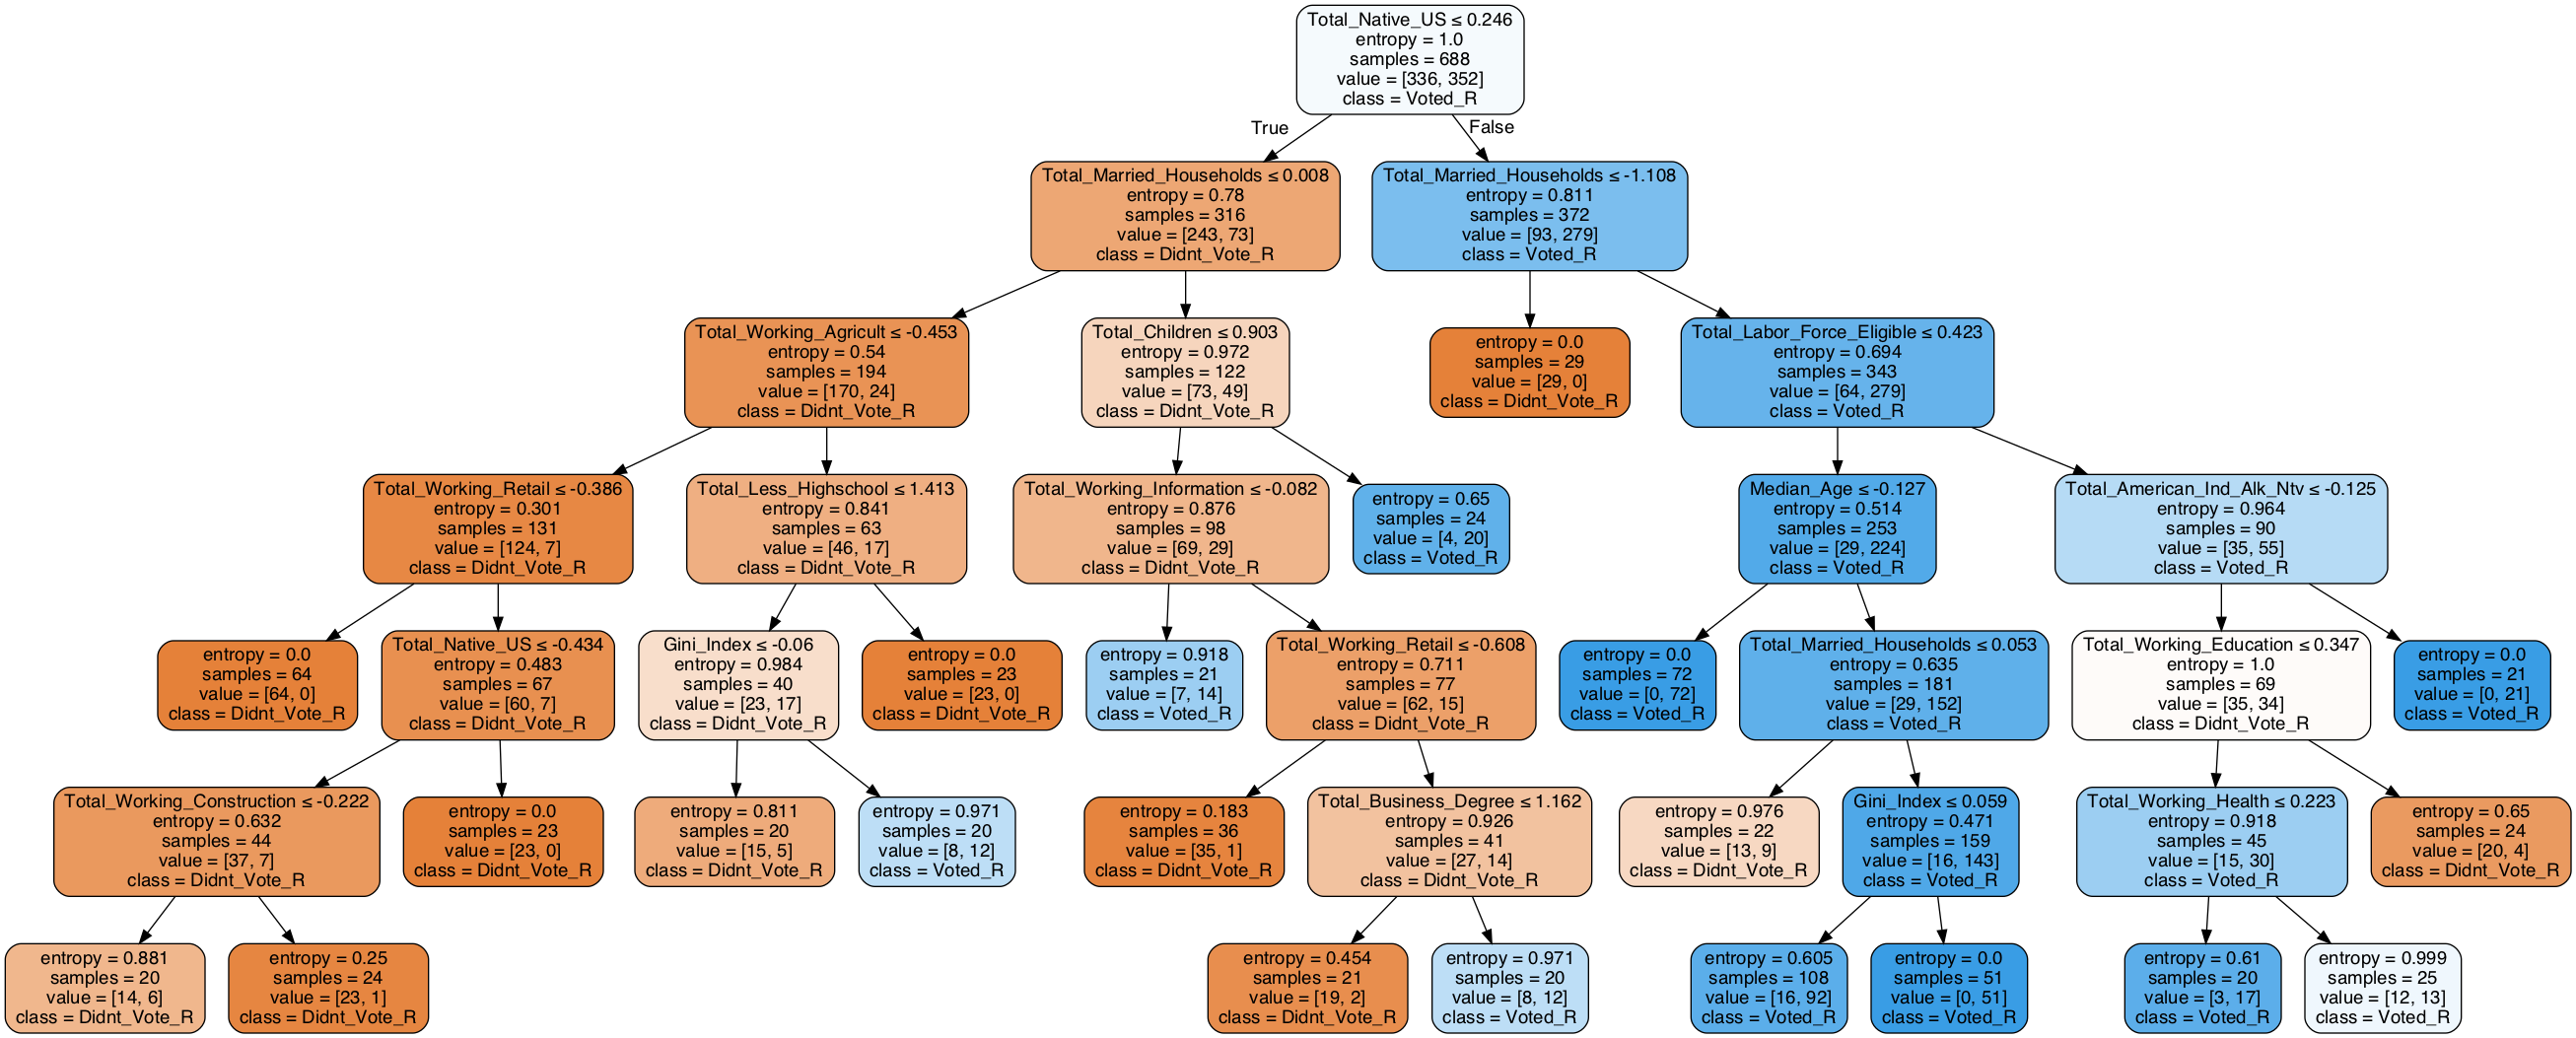

In [99]:
plot_decision_tree(DT_model_3.best_estimator_, list(X_train_DT_model_3.columns), ['Didnt_Vote_R', 'Voted_R'], 'DT_model_3')

## 16. Decision Trees - Grid Search - Engineered Set

In [100]:
#Splits the data for the decision tree model gridsearch, using the engineered features
X_train_DT_model_4, X_test_DT_model_4, y_train_DT_model_4, y_test_DT_model_4 =  reset_data('engineered')

sc_DT_model_4=StandardScaler()
X_train_scaled_DT_model_4= sc_DT_model_4.fit_transform(X_train_DT_model_4)
X_test_scaled_DT_model_4 = sc_DT_model_4.transform(X_test_DT_model_4)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [101]:
#Parameters and model creation
parameters ={'criterion': ['gini','entropy'], 'min_samples_leaf' : range(5,100,15), 'max_depth': range(2,20,1)}

DT_model_4 = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid= parameters,
                  scoring=scoring, cv=5, refit='AUC', return_train_score=True, verbose = 5)

In [102]:
DT_model_4.fit(X_train_scaled_DT_model_4, y_train_DT_model_4)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=5, AUC=0.7688483844241922, Accuracy=0.762589928057554, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=5, AUC=0.7857893630439352, Accuracy=0.7753623188405797, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=5, AUC=0.8216417910447762, Accuracy=0.8029197080291971, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=5, AUC=0.8337953091684436, Accuracy=0.8102189781021898, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=5, AUC=0.812366737739872, Accuracy=0.76642

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=2, min_samples_leaf=80, AUC=0.7946184570107211, Accuracy=0.7246376811594203, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=80 ................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=80, AUC=0.7889125799573562, Accuracy=0.6934306569343066, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=80 ................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=80, AUC=0.8227078891257995, Accuracy=0.7518248175182481, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=80 ................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=80, AUC=0.8014925373134327, Accuracy=0.7299270072992701, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=95 ................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=95, AUC=0.7929784589892295, Accuracy=0.7697841726618705, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=95 ................
[CV]  criterion=gini, max_dept

[CV]  criterion=gini, max_depth=4, min_samples_leaf=20, AUC=0.8176263463131731, Accuracy=0.762589928057554, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=20 ................
[CV]  criterion=gini, max_depth=4, min_samples_leaf=20, AUC=0.8609417700231238, Accuracy=0.782608695652174, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=20 ................
[CV]  criterion=gini, max_depth=4, min_samples_leaf=20, AUC=0.8603411513859275, Accuracy=0.8102189781021898, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=20 ................
[CV]  criterion=gini, max_depth=4, min_samples_leaf=20, AUC=0.8312366737739872, Accuracy=0.7664233576642335, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=20 ................
[CV]  criterion=gini, max_depth=4, min_samples_leaf=20, AUC=0.8607675906183369, Accuracy=0.8102189781021898, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=35 ................
[CV]  criterion=gini, max_depth=

[CV]  criterion=gini, max_depth=5, min_samples_leaf=35, AUC=0.8312366737739871, Accuracy=0.781021897810219, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=50 ................
[CV]  criterion=gini, max_depth=5, min_samples_leaf=50, AUC=0.82549710024855, Accuracy=0.7697841726618705, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=50 ................
[CV]  criterion=gini, max_depth=5, min_samples_leaf=50, AUC=0.8544250578095438, Accuracy=0.782608695652174, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=50 ................
[CV]  criterion=gini, max_depth=5, min_samples_leaf=50, AUC=0.805863539445629, Accuracy=0.708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=50 ................
[CV]  criterion=gini, max_depth=5, min_samples_leaf=50, AUC=0.8517057569296376, Accuracy=0.7956204379562044, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=50 ................
[CV]  criterion=gini, max_depth=5, m

[CV]  criterion=gini, max_depth=6, min_samples_leaf=65, AUC=0.8257995735607675, Accuracy=0.781021897810219, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_leaf=65 ................
[CV]  criterion=gini, max_depth=6, min_samples_leaf=65, AUC=0.8315565031982943, Accuracy=0.7591240875912408, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_leaf=80 ................
[CV]  criterion=gini, max_depth=6, min_samples_leaf=80, AUC=0.8133802816901409, Accuracy=0.762589928057554, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_leaf=80 ................
[CV]  criterion=gini, max_depth=6, min_samples_leaf=80, AUC=0.804078200546563, Accuracy=0.7246376811594203, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_leaf=80 ................
[CV]  criterion=gini, max_depth=6, min_samples_leaf=80, AUC=0.8257995735607677, Accuracy=0.6934306569343066, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_leaf=80 ................
[CV]  criterion=gini, max_depth=6

[CV]  criterion=gini, max_depth=7, min_samples_leaf=95, AUC=0.8453091684434968, Accuracy=0.7664233576642335, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=95 ................
[CV]  criterion=gini, max_depth=7, min_samples_leaf=95, AUC=0.809594882729211, Accuracy=0.7299270072992701, total=   0.0s
[CV] criterion=gini, max_depth=8, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=8, min_samples_leaf=5, AUC=0.8069594034797017, Accuracy=0.7553956834532374, total=   0.0s
[CV] criterion=gini, max_depth=8, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=8, min_samples_leaf=5, AUC=0.7687618246794198, Accuracy=0.7463768115942029, total=   0.0s
[CV] criterion=gini, max_depth=8, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=8, min_samples_leaf=5, AUC=0.7980810234541578, Accuracy=0.7153284671532847, total=   0.0s
[CV] criterion=gini, max_depth=8, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=8,

[CV]  criterion=gini, max_depth=9, min_samples_leaf=80, AUC=0.8257995735607677, Accuracy=0.6934306569343066, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=80 ................
[CV]  criterion=gini, max_depth=9, min_samples_leaf=80, AUC=0.8286780383795309, Accuracy=0.7518248175182481, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=80 ................
[CV]  criterion=gini, max_depth=9, min_samples_leaf=80, AUC=0.8211087420042644, Accuracy=0.7299270072992701, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=95 ................
[CV]  criterion=gini, max_depth=9, min_samples_leaf=95, AUC=0.8131731565865783, Accuracy=0.7697841726618705, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=95 ................
[CV]  criterion=gini, max_depth=9, min_samples_leaf=95, AUC=0.8018709270548665, Accuracy=0.7246376811594203, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=95 ................
[CV]  criterion=gini, max_dept

[CV]  criterion=gini, max_depth=11, min_samples_leaf=5, AUC=0.7963001891948707, Accuracy=0.7536231884057971, total=   0.0s
[CV] criterion=gini, max_depth=11, min_samples_leaf=5 ................
[CV]  criterion=gini, max_depth=11, min_samples_leaf=5, AUC=0.7889125799573561, Accuracy=0.7518248175182481, total=   0.0s
[CV] criterion=gini, max_depth=11, min_samples_leaf=5 ................
[CV]  criterion=gini, max_depth=11, min_samples_leaf=5, AUC=0.7950959488272922, Accuracy=0.7883211678832117, total=   0.0s
[CV] criterion=gini, max_depth=11, min_samples_leaf=5 ................
[CV]  criterion=gini, max_depth=11, min_samples_leaf=5, AUC=0.8121535181236674, Accuracy=0.7664233576642335, total=   0.0s
[CV] criterion=gini, max_depth=11, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=11, min_samples_leaf=20, AUC=0.8092377796188898, Accuracy=0.7410071942446043, total=   0.0s
[CV] criterion=gini, max_depth=11, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_dep

[CV]  criterion=gini, max_depth=12, min_samples_leaf=95, AUC=0.8057569296375268, Accuracy=0.6934306569343066, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_leaf=95 ...............
[CV]  criterion=gini, max_depth=12, min_samples_leaf=95, AUC=0.8453091684434968, Accuracy=0.7664233576642335, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_leaf=95 ...............
[CV]  criterion=gini, max_depth=12, min_samples_leaf=95, AUC=0.809594882729211, Accuracy=0.7299270072992701, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=5 ................
[CV]  criterion=gini, max_depth=13, min_samples_leaf=5, AUC=0.8090306545153273, Accuracy=0.7553956834532374, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=5 ................
[CV]  criterion=gini, max_depth=13, min_samples_leaf=5, AUC=0.7963001891948707, Accuracy=0.7536231884057971, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=5 ................
[CV]  criterion=gini, max_de

[CV]  criterion=gini, max_depth=14, min_samples_leaf=65, AUC=0.809594882729211, Accuracy=0.708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=14, min_samples_leaf=65 ...............
[CV]  criterion=gini, max_depth=14, min_samples_leaf=65, AUC=0.8257995735607675, Accuracy=0.781021897810219, total=   0.0s
[CV] criterion=gini, max_depth=14, min_samples_leaf=65 ...............
[CV]  criterion=gini, max_depth=14, min_samples_leaf=65, AUC=0.8315565031982943, Accuracy=0.7591240875912408, total=   0.0s
[CV] criterion=gini, max_depth=14, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_depth=14, min_samples_leaf=80, AUC=0.8133802816901409, Accuracy=0.762589928057554, total=   0.0s
[CV] criterion=gini, max_depth=14, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_depth=14, min_samples_leaf=80, AUC=0.804078200546563, Accuracy=0.7246376811594203, total=   0.0s
[CV] criterion=gini, max_depth=14, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_dept

[CV]  criterion=gini, max_depth=15, min_samples_leaf=95, AUC=0.8057569296375268, Accuracy=0.6934306569343066, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=95 ...............
[CV]  criterion=gini, max_depth=15, min_samples_leaf=95, AUC=0.8453091684434968, Accuracy=0.7664233576642335, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=95 ...............
[CV]  criterion=gini, max_depth=15, min_samples_leaf=95, AUC=0.809594882729211, Accuracy=0.7299270072992701, total=   0.0s
[CV] criterion=gini, max_depth=16, min_samples_leaf=5 ................
[CV]  criterion=gini, max_depth=16, min_samples_leaf=5, AUC=0.8090306545153273, Accuracy=0.7553956834532374, total=   0.0s
[CV] criterion=gini, max_depth=16, min_samples_leaf=5 ................
[CV]  criterion=gini, max_depth=16, min_samples_leaf=5, AUC=0.7963001891948707, Accuracy=0.7536231884057971, total=   0.0s
[CV] criterion=gini, max_depth=16, min_samples_leaf=5 ................
[CV]  criterion=gini, max_de

[CV]  criterion=gini, max_depth=17, min_samples_leaf=80, AUC=0.8257995735607677, Accuracy=0.6934306569343066, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_depth=17, min_samples_leaf=80, AUC=0.8286780383795309, Accuracy=0.7518248175182481, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_depth=17, min_samples_leaf=80, AUC=0.8211087420042644, Accuracy=0.7299270072992701, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=95 ...............
[CV]  criterion=gini, max_depth=17, min_samples_leaf=95, AUC=0.8131731565865783, Accuracy=0.7697841726618705, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=95 ...............
[CV]  criterion=gini, max_depth=17, min_samples_leaf=95, AUC=0.8018709270548665, Accuracy=0.7246376811594203, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=95 ...............
[CV]  criterion=gini, max

[CV]  criterion=gini, max_depth=19, min_samples_leaf=5, AUC=0.7889125799573561, Accuracy=0.7518248175182481, total=   0.0s
[CV] criterion=gini, max_depth=19, min_samples_leaf=5 ................
[CV]  criterion=gini, max_depth=19, min_samples_leaf=5, AUC=0.7950959488272922, Accuracy=0.7883211678832117, total=   0.0s
[CV] criterion=gini, max_depth=19, min_samples_leaf=5 ................
[CV]  criterion=gini, max_depth=19, min_samples_leaf=5, AUC=0.8121535181236674, Accuracy=0.7664233576642335, total=   0.0s
[CV] criterion=gini, max_depth=19, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=19, min_samples_leaf=20, AUC=0.8092377796188898, Accuracy=0.7410071942446043, total=   0.0s
[CV] criterion=gini, max_depth=19, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=19, min_samples_leaf=20, AUC=0.8643052343914231, Accuracy=0.7898550724637681, total=   0.0s
[CV] criterion=gini, max_depth=19, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_de

[CV]  criterion=entropy, max_depth=2, min_samples_leaf=35, AUC=0.7968017057569297, Accuracy=0.8029197080291971, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=35 .............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=35, AUC=0.8305970149253731, Accuracy=0.7956204379562044, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=35 .............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=35, AUC=0.8052238805970149, Accuracy=0.7591240875912408, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=50, AUC=0.7664664457332229, Accuracy=0.7697841726618705, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=50, AUC=0.8136430523439142, Accuracy=0.782608695652174, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=50 .............
[CV]  criterion=

[CV]  criterion=entropy, max_depth=3, min_samples_leaf=50, AUC=0.8315565031982943, Accuracy=0.7664233576642335, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=65, AUC=0.8182477216238608, Accuracy=0.7769784172661871, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=65, AUC=0.81595543409712, Accuracy=0.7753623188405797, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=65, AUC=0.7857142857142858, Accuracy=0.7007299270072993, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=65, AUC=0.829317697228145, Accuracy=0.781021897810219, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=65 .............
[CV]  criterion=ent

[CV]  criterion=entropy, max_depth=5, min_samples_leaf=20, AUC=0.83955223880597, Accuracy=0.7518248175182481, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=20, AUC=0.8619402985074627, Accuracy=0.8102189781021898, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=35 .............
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=35, AUC=0.8294324772162385, Accuracy=0.7553956834532374, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=35 .............
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=35, AUC=0.8315114568005046, Accuracy=0.7681159420289855, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=35 .............
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=35, AUC=0.8544776119402986, Accuracy=0.8175182481751825, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=35 .............
[CV]  criterion=e

[CV]  criterion=entropy, max_depth=6, min_samples_leaf=80, AUC=0.8122601279317697, Accuracy=0.7007299270072993, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=80 .............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=80, AUC=0.8254797441364605, Accuracy=0.7518248175182481, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=80 .............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=80, AUC=0.8211087420042644, Accuracy=0.7299270072992701, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=95 .............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=95, AUC=0.8050952775476388, Accuracy=0.7697841726618705, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=95 .............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=95, AUC=0.8018709270548665, Accuracy=0.7246376811594203, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=95 .............
[CV]  criterion

[CV]  criterion=entropy, max_depth=8, min_samples_leaf=5, AUC=0.8185501066098082, Accuracy=0.781021897810219, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=20, AUC=0.8054059652029826, Accuracy=0.7194244604316546, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=20, AUC=0.8258356106789995, Accuracy=0.7898550724637681, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=20, AUC=0.8566098081023454, Accuracy=0.7518248175182481, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=20, AUC=0.8303837953091684, Accuracy=0.7518248175182481, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=20 .............
[CV]  criterion=e

[CV]  criterion=entropy, max_depth=9, min_samples_leaf=50, AUC=0.8374200426439233, Accuracy=0.7664233576642335, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=9, min_samples_leaf=65, AUC=0.8216652858326429, Accuracy=0.7769784172661871, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=9, min_samples_leaf=65, AUC=0.8231027958797562, Accuracy=0.7753623188405797, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=9, min_samples_leaf=65, AUC=0.7881663113006396, Accuracy=0.7007299270072993, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=9, min_samples_leaf=65, AUC=0.8343283582089552, Accuracy=0.781021897810219, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=65 .............
[CV]  criterion=

[CV]  criterion=entropy, max_depth=11, min_samples_leaf=5, AUC=0.8313432835820895, Accuracy=0.7737226277372263, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=5, AUC=0.8047974413646056, Accuracy=0.7737226277372263, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=20, AUC=0.8054059652029826, Accuracy=0.7194244604316546, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=20, AUC=0.8258356106789995, Accuracy=0.7898550724637681, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=20, AUC=0.8566098081023454, Accuracy=0.7518248175182481, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=20 ............
[CV]  criter

[CV]  criterion=entropy, max_depth=12, min_samples_leaf=50, AUC=0.8374200426439233, Accuracy=0.7664233576642335, total=   0.0s
[CV] criterion=entropy, max_depth=12, min_samples_leaf=65 ............
[CV]  criterion=entropy, max_depth=12, min_samples_leaf=65, AUC=0.8216652858326429, Accuracy=0.7769784172661871, total=   0.0s
[CV] criterion=entropy, max_depth=12, min_samples_leaf=65 ............
[CV]  criterion=entropy, max_depth=12, min_samples_leaf=65, AUC=0.8231027958797562, Accuracy=0.7753623188405797, total=   0.0s
[CV] criterion=entropy, max_depth=12, min_samples_leaf=65 ............
[CV]  criterion=entropy, max_depth=12, min_samples_leaf=65, AUC=0.7881663113006396, Accuracy=0.7007299270072993, total=   0.0s
[CV] criterion=entropy, max_depth=12, min_samples_leaf=65 ............
[CV]  criterion=entropy, max_depth=12, min_samples_leaf=65, AUC=0.8343283582089552, Accuracy=0.781021897810219, total=   0.0s
[CV] criterion=entropy, max_depth=12, min_samples_leaf=65 ............
[CV]  crite

[CV]  criterion=entropy, max_depth=14, min_samples_leaf=5, AUC=0.8047974413646056, Accuracy=0.7737226277372263, total=   0.0s
[CV] criterion=entropy, max_depth=14, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=14, min_samples_leaf=20, AUC=0.8054059652029826, Accuracy=0.7194244604316546, total=   0.0s
[CV] criterion=entropy, max_depth=14, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=14, min_samples_leaf=20, AUC=0.8258356106789995, Accuracy=0.7898550724637681, total=   0.0s
[CV] criterion=entropy, max_depth=14, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=14, min_samples_leaf=20, AUC=0.8566098081023454, Accuracy=0.7518248175182481, total=   0.0s
[CV] criterion=entropy, max_depth=14, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=14, min_samples_leaf=20, AUC=0.8303837953091684, Accuracy=0.7518248175182481, total=   0.0s
[CV] criterion=entropy, max_depth=14, min_samples_leaf=20 ............
[CV]  crite

[CV]  criterion=entropy, max_depth=15, min_samples_leaf=65, AUC=0.8231027958797562, Accuracy=0.7753623188405797, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=65 ............
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=65, AUC=0.7881663113006396, Accuracy=0.7007299270072993, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=65 ............
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=65, AUC=0.8343283582089552, Accuracy=0.781021897810219, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=65 ............
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=65, AUC=0.8315565031982943, Accuracy=0.7591240875912408, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=80 ............
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=80, AUC=0.7966031483015742, Accuracy=0.762589928057554, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=80 ............
[CV]  criter

[CV]  criterion=entropy, max_depth=17, min_samples_leaf=5, AUC=0.7666311300639659, Accuracy=0.7299270072992701, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=5, AUC=0.8313432835820895, Accuracy=0.7737226277372263, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=5, AUC=0.8047974413646056, Accuracy=0.7737226277372263, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=20, AUC=0.8054059652029826, Accuracy=0.7194244604316546, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=20, AUC=0.8258356106789995, Accuracy=0.7898550724637681, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=20 ............
[CV]  criteri

[CV]  criterion=entropy, max_depth=18, min_samples_leaf=50, AUC=0.8430703624733475, Accuracy=0.7956204379562044, total=   0.0s
[CV] criterion=entropy, max_depth=18, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=18, min_samples_leaf=50, AUC=0.8374200426439233, Accuracy=0.7664233576642335, total=   0.0s
[CV] criterion=entropy, max_depth=18, min_samples_leaf=65 ............
[CV]  criterion=entropy, max_depth=18, min_samples_leaf=65, AUC=0.8216652858326429, Accuracy=0.7769784172661871, total=   0.0s
[CV] criterion=entropy, max_depth=18, min_samples_leaf=65 ............
[CV]  criterion=entropy, max_depth=18, min_samples_leaf=65, AUC=0.8231027958797562, Accuracy=0.7753623188405797, total=   0.0s
[CV] criterion=entropy, max_depth=18, min_samples_leaf=65 ............
[CV]  criterion=entropy, max_depth=18, min_samples_leaf=65, AUC=0.7881663113006396, Accuracy=0.7007299270072993, total=   0.0s
[CV] criterion=entropy, max_depth=18, min_samples_leaf=65 ............
[CV]  crit

[Parallel(n_jobs=1)]: Done 1260 out of 1260 | elapsed:   13.3s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'min_samples_leaf': range(5, 100, 15), 'max_depth': range(2, 20)},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score=True,
       scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)},
       verbose=5)

In [103]:
# Predict on training data with best params
y_pred_train_DT_model_4 = DT_model_4.predict(X_train_scaled_DT_model_4)

#Predict the response for test dataset
y_pred_test_DT_model_4 = DT_model_4.predict(X_test_scaled_DT_model_4)

# Prints the accuracy and f1 scores
print("Training Accuracy for Decision Tree Model 4 GS (Engineered Features):", accuracy_score(y_train_DT_model_4, y_pred_train_DT_model_4))
print("Training F1 Score for Decision Tree Model 4 GS (Engineered Features):", f1_score(y_train_DT_model_4, y_pred_train_DT_model_4))
print("")
print("Testing Accuracy for Decision Tree Model 4 GS (Engineered Features):", accuracy_score(y_test_DT_model_4, y_pred_test_DT_model_4))
print("Testing F1 Score for Decision Tree Model 4 GS (Engineered Features):", f1_score(y_test_DT_model_4, y_pred_test_DT_model_4))

Training Accuracy for Decision Tree Model 4 GS (Engineered Features): 0.8546511627906976
Training F1 Score for Decision Tree Model 4 GS (Engineered Features): 0.8648648648648649

Testing Accuracy for Decision Tree Model 4 GS (Engineered Features): 0.7674418604651163
Testing F1 Score for Decision Tree Model 4 GS (Engineered Features): 0.7916666666666667


In [104]:
print('The top score for a decision tree is: ' + str(DT_model_4.best_score_))
print('The parameters for the top performing decision tree is: ' + str(DT_model_4.best_params_))
print('The top performing decision tree is: ')
print(DT_model_4.best_estimator_)

The top score for a decision tree is: 0.8493255797572045
The parameters for the top performing decision tree is: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 20}
The top performing decision tree is: 
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')


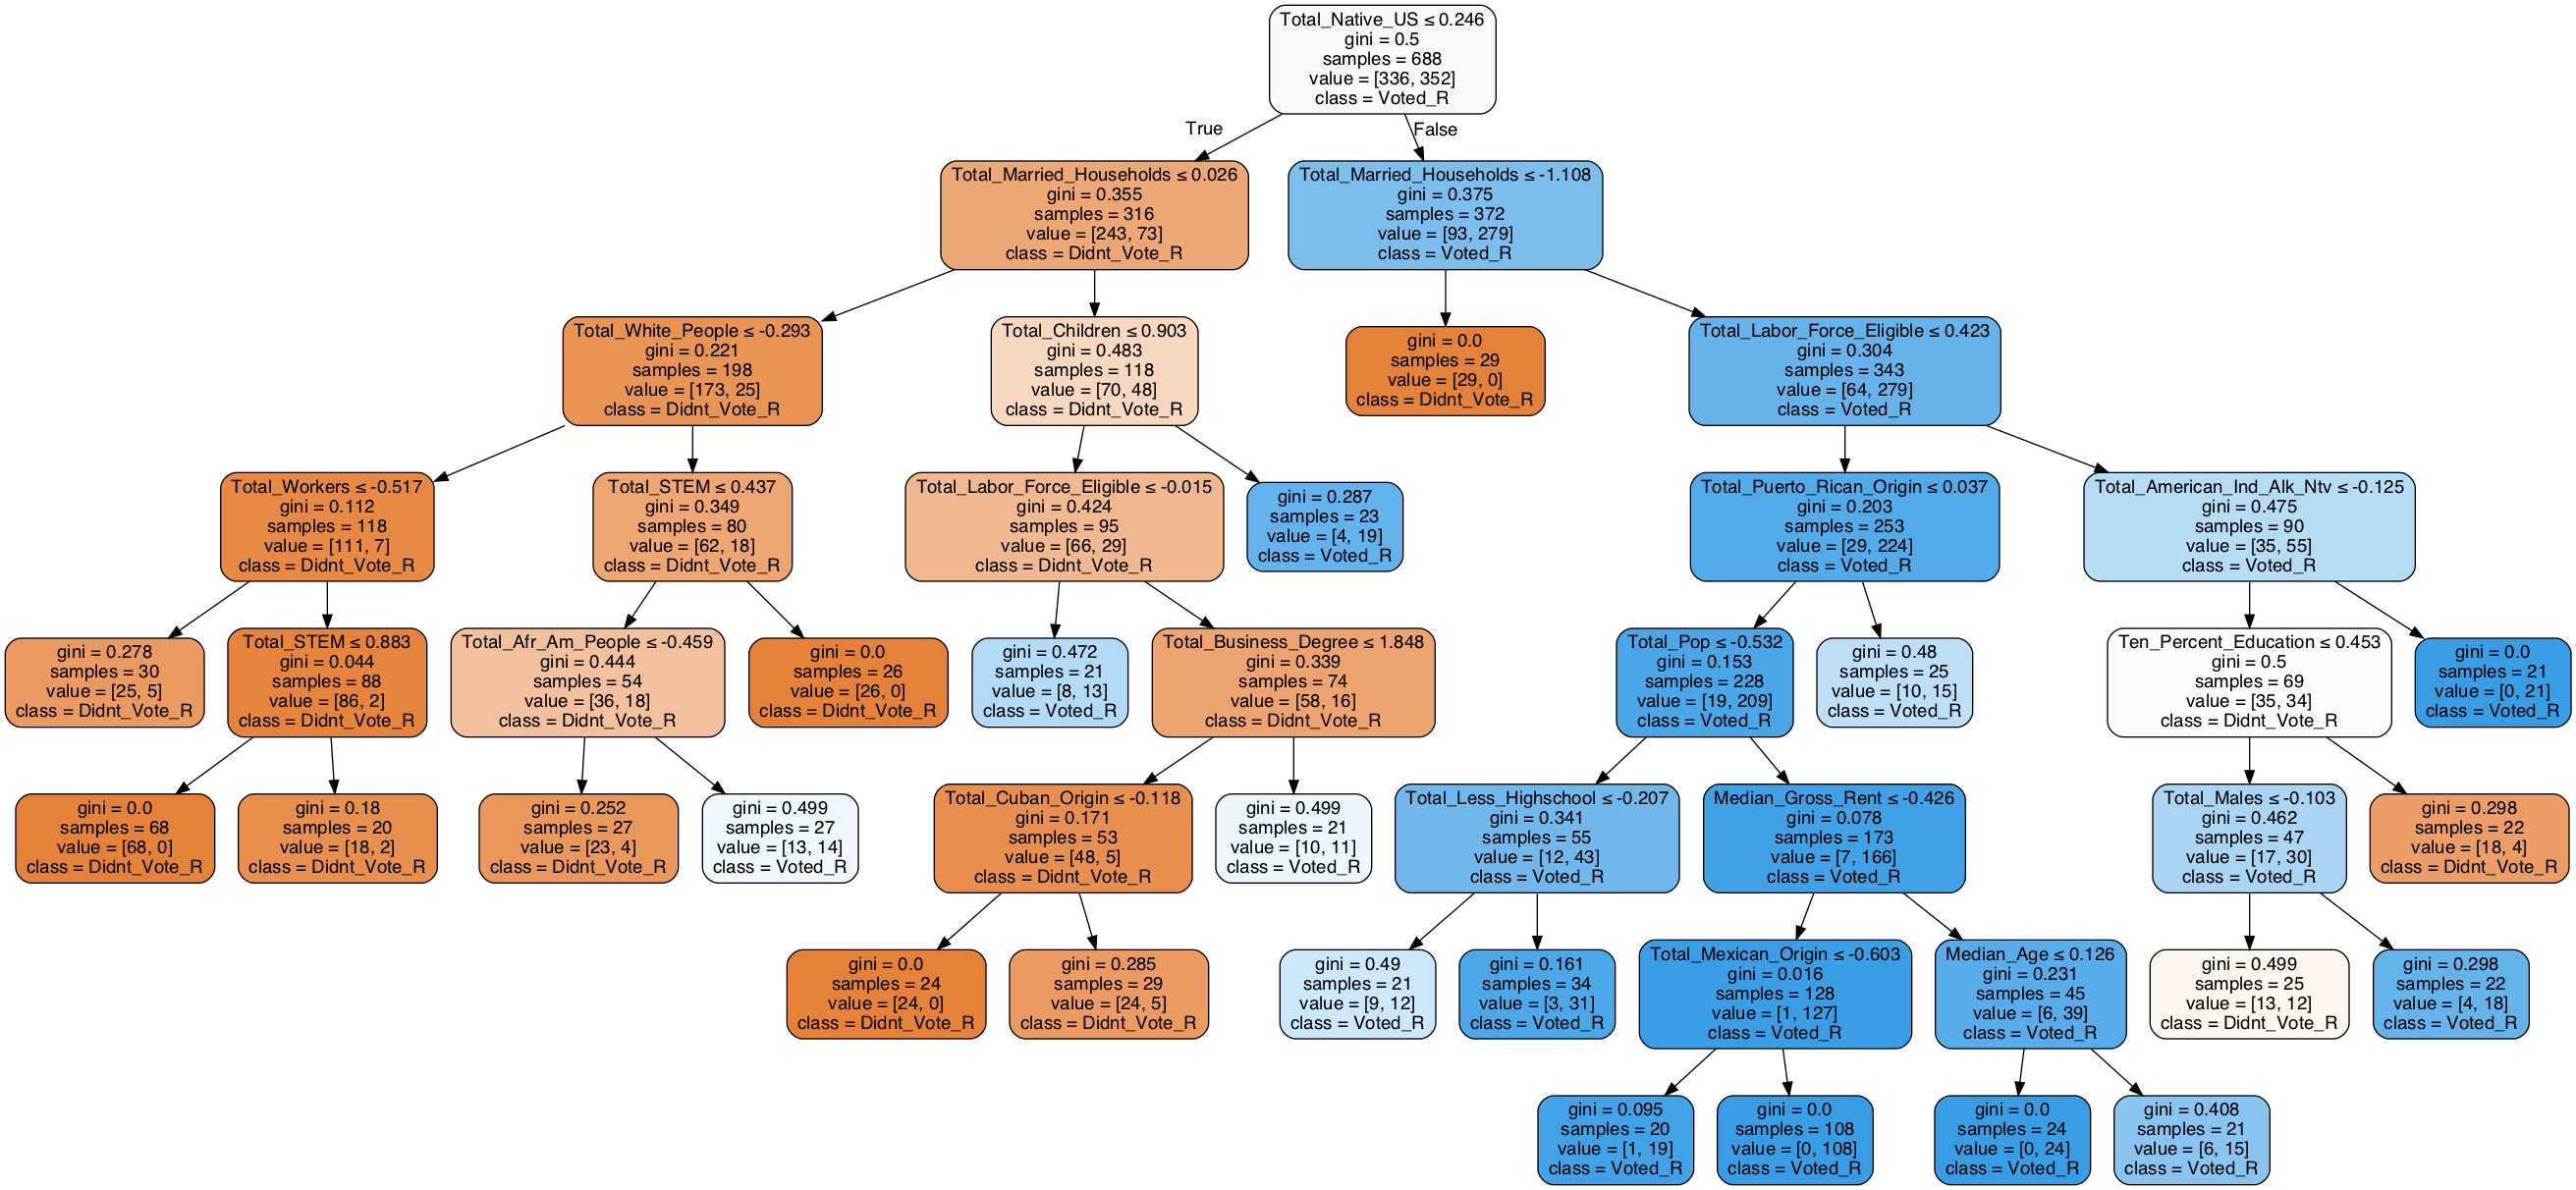

In [105]:
plot_decision_tree(DT_model_4.best_estimator_, list(X_train_DT_model_4.columns), ['Didnt_Vote_R', 'Voted_R'], 'DT_model_4')

## 17. Random Forest - Standard Set

In [106]:
#Creates the parameters for the random forest model
param_grid = { 
    'n_estimators': [200,300,400],
    'max_features': [0.25, 0.33, 0.5 ],
    'max_depth' : [5,6,7,8,9],
    'min_samples_leaf': [0.03,0.04,0.05,0.06]
}

In [107]:
#Splits the data for the random forest model using the standard features
X_train_rfc_model_1, X_test_rfc_model_1, y_train_rfc_model_1, y_test_rfc_model_1 =  reset_data()

sc_rfc_model_1=StandardScaler()
X_train_scaled_rfc_model_1= sc_rfc_model_1.fit_transform(X_train_rfc_model_1)
X_test_scaled_rfc_model_1 = sc_rfc_model_1.transform(X_test_rfc_model_1)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [108]:
#Fits the rf model
rfc_model_1 = GridSearchCV(estimator= RandomForestClassifier(random_state = 23), param_grid=param_grid, cv= 5, n_jobs=-1, verbose = 5)
rfc_model_1.fit(X_train_scaled_rfc_model_1, y_train_rfc_model_1)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  2.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=23, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [200, 300, 400], 'max_features': [0.25, 0.33, 0.5], 'max_depth': [5, 6, 7, 8, 9], 'min_samples_leaf': [0.03, 0.04, 0.05, 0.06]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [ ]:
#Loading the saved random forest model with pickle
#rfc_model_1_pkl = open('./Classification_Models_After_rfc_model_1.pkl', 'rb')
#rfc_model_1 = pickle.load(rfc_model_1_pkl)
#print("Loaded rfc_model_1 Pickle :: ", rfc_model_1)
#print(rfc_model_1.best_estimator_.get_params())

In [109]:
# Predict on training data with best params
pred_rfc_model_1_train = rfc_model_1.predict(X_train_scaled_rfc_model_1)
#Predict the response for test dataset
pred_rfc_model_1 = rfc_model_1.predict(X_test_scaled_rfc_model_1)

In [110]:
# Prints the accuracy and f1 scores
print("Training Accuracy for Random Forest Model 1 (Standard Features):", accuracy_score(y_train_rfc_model_1, pred_rfc_model_1_train))
print("Training F1 Score for Random Forest Model 1 (Standard Features):", f1_score(y_train_rfc_model_1, pred_rfc_model_1_train))
print("")
print("Testing Accuracy for Random Forest Model 1 (Standard Features):", accuracy_score(y_test_rfc_model_1, pred_rfc_model_1))
print("Testing F1 Score for Random Forest Model 1 (Standard Features):", f1_score(y_test_rfc_model_1, pred_rfc_model_1))

Training Accuracy for Random Forest Model 1 (Standard Features): 0.8546511627906976
Training F1 Score for Random Forest Model 1 (Standard Features): 0.8587570621468926

Testing Accuracy for Random Forest Model 1 (Standard Features): 0.7732558139534884
Testing F1 Score for Random Forest Model 1 (Standard Features): 0.7868852459016393


In [111]:
print('The top score for a random forest is: ' + str(rfc_model_1.best_score_))
print('The parameters for the top performing random forest is: ' + str(rfc_model_1.best_params_))
print('The top performing random forest is: ')
print(rfc_model_1.best_estimator_)

The top score for a random forest is: 0.815406976744186
The parameters for the top performing random forest is: {'max_depth': 6, 'max_features': 0.25, 'min_samples_leaf': 0.03, 'n_estimators': 300}
The top performing random forest is: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=0.25, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.03, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=23, verbose=0, warm_start=False)


In [ ]:
#Run this code to save the random forest model data
#make_pickle(rfc_model_1, 'rfc_model_1')

## 18. Random Forest - Engineered Set

In [112]:
#Splits the data for the random forest model using the engineered features
X_train_rfc_model_2, X_test_rfc_model_2, y_train_rfc_model_2, y_test_rfc_model_2 =  reset_data('engineered')

sc_rfc_model_2=StandardScaler()
X_train_scaled_rfc_model_2= sc_rfc_model_2.fit_transform(X_train_rfc_model_2)
X_test_scaled_rfc_model_2 = sc_rfc_model_2.transform(X_test_rfc_model_2)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [113]:
#Fits the rf model
rfc_model_2 = GridSearchCV(estimator= RandomForestClassifier(random_state = 23), param_grid=param_grid, cv= 5, n_jobs=-1, verbose = 5)
rfc_model_2.fit(X_train_scaled_rfc_model_2, y_train_rfc_model_2)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  2.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=23, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [200, 300, 400], 'max_features': [0.25, 0.33, 0.5], 'max_depth': [5, 6, 7, 8, 9], 'min_samples_leaf': [0.03, 0.04, 0.05, 0.06]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [114]:
#Loading the saved random forest smote model with pickle
#rfc_model_2_pkl = open('./Classification_Models_After_rfc_model_2.pkl', 'rb')
#rfc_model_2 = pickle.load(rfc_model_2_pkl)
#print("Loaded rfc_model_2 Pickle :: ", rfc_model_2)
#print(rfc_model_2.best_estimator_.get_params())

In [115]:
# Predict on training data with best params
pred_rfc_model_2_train = rfc_model_2.predict(X_train_scaled_rfc_model_2)
#Predict the response for test dataset
pred_rfc_model_2 = rfc_model_2.predict(X_test_scaled_rfc_model_2)

In [117]:
# Prints the accuracy and f1 scores
print("Training Accuracy for Random Forest Model 2 (Engineered Features):", accuracy_score(y_train_rfc_model_2, pred_rfc_model_2_train))
print("Training F1 Score for Random Forest Model 2 (Engineered Features):", f1_score(y_train_rfc_model_2, pred_rfc_model_2_train))
print("")
print("Testing Accuracy for Random Forest Model 2 (Engineered Features):", accuracy_score(y_test_rfc_model_2, pred_rfc_model_2))
print("Testing F1 Score for Random Forest Model 2 (Engineered Features):", f1_score(y_test_rfc_model_2, pred_rfc_model_2))

Training Accuracy for Random Forest Model 2 (Engineered Features): 0.8517441860465116
Training F1 Score for Random Forest Model 2 (Engineered Features): 0.8551136363636364

Testing Accuracy for Random Forest Model 2 (Engineered Features): 0.7790697674418605
Testing F1 Score for Random Forest Model 2 (Engineered Features): 0.7912087912087912


In [118]:
print('The top score for a random forest is: ' + str(rfc_model_2.best_score_))
print('The parameters for the top performing random forest is: ' + str(rfc_model_2.best_params_))
print('The top performing random forest is: ')
print(rfc_model_2.best_estimator_)

The top score for a random forest is: 0.8125
The parameters for the top performing random forest is: {'max_depth': 5, 'max_features': 0.33, 'min_samples_leaf': 0.03, 'n_estimators': 300}
The top performing random forest is: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=0.33, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.03, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=23, verbose=0, warm_start=False)


In [119]:
#Run this code to save the random forest model data
#make_pickle(rfc_model_2, 'rfc_model_2')

## 19. XGBoost - Standard Set

In [120]:
#Make a df copy specifically for XGBoost

election_df_xgb = election_df.copy()

#Makes a features for later reference
features_list_xgb_model_1 = ['Total_Pop', 'Total_Males',
                         'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People',
                         'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian',
                         'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin', 'Total_Cuban_Origin',
                         'Total_Dominican_Origin', 'Total_Native_US', 'Total_Non_Citizens',
                         'Total_Foreign_Born', 'Median_Income', 'Median_Household_Income',
                         'Below_Poverty_Level_LTM', 'Total_Wealthy_Households', 'Gini_Index',
                         'Total_Less_Highschool', 'Total_Bachelor_Holders', 'Total_STEM',
                         'Total_Business_Degree', 'Total_Married_Households', 'Total_Veterans',
                         'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed',
                         'Median_Age_Of_Worker', 'Total_Workers', 'Total_Working_Agricult',
                         'Total_Working_Construction', 'Total_Working_Manufacturing',
                         'Total_Working_Retail', 'Total_Working_Transportation',
                         'Total_Working_Information', 'Total_Working_Finance', 
                         'Total_Working_Education', 'Total_Working_Health', 'Total_Working_Food',
                         'Total_Working_Public_Admin', 'Median_Gross_Rent']

#Separates the two dataframes
X_xgb_model_1 = election_df_xgb[features_list_xgb_model_1]
y_xgb_model_1 = election_df_xgb['Target_Presidential_R_bool']


In [121]:
#Scales the features and then splits them
scaler_xgb_model_1 = StandardScaler()
scaled_df_xgb_model_1 = scaler_xgb_model_1.fit_transform(X_xgb_model_1)

X_train_xgb_model_1, X_test_xgb_model_1, y_train_xgb_model_1, y_test_xgb_model_1 = train_test_split(scaled_df_xgb_model_1, y_xgb_model_1)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [122]:
#fits and then scores the XGBoost model
xgb_model_1 = xgb.XGBClassifier()
xgb_model_1.fit(X_train_xgb_model_1, y_train_xgb_model_1)
training_preds_xgb_model_1 = xgb_model_1.predict(X_train_xgb_model_1)
val_preds_xgb_model_1 = xgb_model_1.predict(X_test_xgb_model_1)
training_accuracy_xgb_model_1 = accuracy_score(y_train_xgb_model_1, training_preds_xgb_model_1)
val_accuracy_xgb_model_1 = accuracy_score(y_test_xgb_model_1, val_preds_xgb_model_1)

print("Training Accuracy for the standard model: {:.4}%".format(training_accuracy_xgb_model_1 * 100))
print("Validation Accuracy for the standard model: {:.4}%".format(val_accuracy_xgb_model_1 * 100))

Training Accuracy for the standard model: 98.45%
Validation Accuracy for the standard model: 86.05%


In [123]:
#Creates a parameter grid for the gridsearch of XGBoost
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [6],
    'min_child_weight': [10],
    'subsample': [ 0.7],
    'n_estimators': [5, 30, 100, 250],
}

In [124]:
#Creates an XGBoost model
xgb_model_1 = xgb.XGBClassifier()

In [125]:
#Fits the data to the model
xgb_model_1 = GridSearchCV(xgb_model_1, param_grid, scoring='accuracy', cv=None, n_jobs=1, verbose = 5)
xgb_model_1.fit(scaled_df_xgb_model_1, y_xgb_model_1)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=5, subsample=0.7 
[CV]  learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=5, subsample=0.7, score=0.8222996515679443, total=   0.0s
[CV] learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=5, subsample=0.7 
[CV]  learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=5, subsample=0.7, score=0.7630662020905923, total=   0.0s
[CV] learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=5, subsample=0.7 
[CV]  learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=5, subsample=0.7, score=0.7622377622377622, total=   0.0s
[CV] learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=30, subsample=0.7 
[CV]  learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=30, subsample=0.7, score=0.8153310104529616, total=   0.1s
[CV] learning_rate=0.1, max_depth=6, min_child_weight=10, n_es

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    2.1s finished


GridSearchCV(cv=None, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'learning_rate': [0.1], 'max_depth': [6], 'min_child_weight': [10], 'subsample': [0.7], 'n_estimators': [5, 30, 100, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=5)

In [126]:
#Prints the best parameters from the XGBoost model
best_parameters_xgb_model_1 = xgb_model_1.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters_xgb_model_1.keys()):
    print("%s: %r" % (param_name, best_parameters_xgb_model_1[param_name]))

training_preds_xgb_model_1 = xgb_model_1.predict(X_train_xgb_model_1)
val_preds_xgb_model_1 = xgb_model_1.predict(X_test_xgb_model_1)
training_accuracy_xgb_model_1 = accuracy_score(y_train_xgb_model_1, training_preds_xgb_model_1)
val_accuracy_xgb_model_1 = accuracy_score(y_test_xgb_model_1, val_preds_xgb_model_1)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy_xgb_model_1 * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy_xgb_model_1 * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 10
n_estimators: 250
subsample: 0.7

Training Accuracy: 97.67%
Validation accuracy: 99.07%


In [127]:
#Makes predictions for model scoring
y_pred_train_xgb_model_1 = xgb_model_1.predict(X_train_xgb_model_1)
y_pred_test_xgb_model_1 = xgb_model_1.predict(X_test_xgb_model_1)

# Prints the accuracy and f1 scores
print('Training Accuracy for XGBoost Model 1 (Standard Features): %.4f ' % accuracy_score(y_train_xgb_model_1, y_pred_train_xgb_model_1))
print('Training F1 Score for XGBoost Model 1 (Standard Features): %.4f ' % f1_score(y_train_xgb_model_1, y_pred_train_xgb_model_1))
print('')
print('Testing Accuracy for XGBoost Model 1 (Standard Features): %.4f ' % accuracy_score(y_test_xgb_model_1, y_pred_test_xgb_model_1))
print('Testing F1 Score for XGBoost Model 1 (Standard Features): %.4f ' % f1_score(y_test_xgb_model_1, y_pred_test_xgb_model_1))

Training Accuracy for XGBoost Model 1 (Standard Features): 0.9767 
Training F1 Score for XGBoost Model 1 (Standard Features): 0.9780 

Testing Accuracy for XGBoost Model 1 (Standard Features): 0.9907 
Testing F1 Score for XGBoost Model 1 (Standard Features): 0.9901 


## 20. XGBoost - Engineered Set

In [128]:
#Make an engineered df copy specifically for XGBoost

election_df_feature_engineering_xgb = election_df_feature_engineering.copy()

#Makes a features for later reference
features_list_xgb_model_2 = ['Total_Pop', 'Total_Males', 'Total_Females', 'Median_Age',
                         'Total_Children', 'Total_White_People',
                         'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian',
                         'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin',
                         'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US',
                         'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income',
                         'Median_Household_Income', 'Below_Poverty_Level_LTM',
                         'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool',
                         'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree',
                         'Total_Married_Households', 'Total_Veterans',
                         'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed',
                         'Median_Age_Of_Worker', 'Total_Workers', 'Ten_Percent_Manufacturing',
                         'Ten_Percent_Agricult', 'Ten_Percent_Construction',
                         'Ten_Percent_Retail', 'Ten_Percent_Transportation',
                         'Ten_Percent_Finance', 'Ten_Percent_Education', 'Ten_Percent_Health',
                         'Ten_Percent_Food', 'Median_Gross_Rent']

#Separates the two dataframes
X_xgb_model_2 = election_df_feature_engineering_xgb[features_list_xgb_model_2]
y_xgb_model_2 = election_df_feature_engineering_xgb['Target_Presidential_R_bool']

In [129]:
#Scales the features and then splits them
scaler_xgb_model_2 = StandardScaler()
scaled_df_xgb_model_2 = scaler_xgb_model_2.fit_transform(X_xgb_model_2)

X_train_xgb_model_2, X_test_xgb_model_2, y_train_xgb_model_2, y_test_xgb_model_2 = train_test_split(scaled_df_xgb_model_2, y_xgb_model_2)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [130]:
#fits and then scores the XGBoost model
xgb_model_2 = xgb.XGBClassifier()
xgb_model_2.fit(X_train_xgb_model_2, y_train_xgb_model_2)
training_preds_xgb_model_2 = xgb_model_2.predict(X_train_xgb_model_2)
val_preds_xgb_model_2 = xgb_model_2.predict(X_test_xgb_model_2)
training_accuracy_xgb_model_2 = accuracy_score(y_train_xgb_model_2, training_preds_xgb_model_2)
val_accuracy_xgb_model_2 = accuracy_score(y_test_xgb_model_2, val_preds_xgb_model_2)

print("Training Accuracy for the engineered model: {:.4}%".format(training_accuracy_xgb_model_2 * 100))
print("Validation Accuracy for the engineered model: {:.4}%".format(val_accuracy_xgb_model_2 * 100))

Training Accuracy for the engineered model: 97.05%
Validation Accuracy for the engineered model: 85.12%


In [131]:
#Creates an XGBoost model
xgb_model_2 = xgb.XGBClassifier()

In [132]:
#Fits the data to the model
xgb_model_2 = GridSearchCV(xgb_model_2, param_grid, scoring='accuracy', cv=None, n_jobs=1, verbose = 5)
xgb_model_2.fit(scaled_df_xgb_model_2, y_xgb_model_2)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=5, subsample=0.7 
[CV]  learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=5, subsample=0.7, score=0.8118466898954704, total=   0.0s
[CV] learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=5, subsample=0.7 
[CV]  learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=5, subsample=0.7, score=0.7526132404181185, total=   0.0s
[CV] learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=5, subsample=0.7 
[CV]  learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=5, subsample=0.7, score=0.7552447552447552, total=   0.0s
[CV] learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=30, subsample=0.7 
[CV]  learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=30, subsample=0.7, score=0.8257839721254355, total=   0.1s
[CV] learning_rate=0.1, max_depth=6, min_child_weight=10, n_es

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.9s finished


GridSearchCV(cv=None, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'learning_rate': [0.1], 'max_depth': [6], 'min_child_weight': [10], 'subsample': [0.7], 'n_estimators': [5, 30, 100, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=5)

In [133]:
#Prints the best parameters from the XGBoost model
best_parameters_xgb_model_2 = xgb_model_2.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters_xgb_model_2.keys()):
    print("%s: %r" % (param_name, best_parameters_xgb_model_2[param_name]))

training_preds_xgb_model_2 = xgb_model_2.predict(X_train_xgb_model_2)
val_preds_xgb_model_2 = xgb_model_2.predict(X_test_xgb_model_2)
training_accuracy_xgb_model_2 = accuracy_score(y_train_xgb_model_2, training_preds_xgb_model_2)
val_accuracy_xgb_model_2 = accuracy_score(y_test_xgb_model_2, val_preds_xgb_model_2)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy_xgb_model_2 * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy_xgb_model_2 * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 10
n_estimators: 100
subsample: 0.7

Training Accuracy: 92.25%
Validation accuracy: 93.49%


In [134]:
#Makes predictions for model scoring
y_pred_train_xgb_model_2 = xgb_model_2.predict(X_train_xgb_model_2)
y_pred_test_xgb_model_2 = xgb_model_2.predict(X_test_xgb_model_2)

# Prints the accuracy and f1 scores
print('Training Accuracy for XGBoost Model 2 (Engineered Features): {:.4}%'.format(accuracy_score(y_train_xgb_model_2, y_pred_train_xgb_model_2) * 100))
print('Training F1 Score for XGBoost Model 2 (Engineered Features): {:.4}%'.format(f1_score(y_train_xgb_model_2, y_pred_train_xgb_model_2) * 100))
print('')
print('Testing Accuracy for XGBoost Model 2 (Engineered Features): {:.4}%'.format(accuracy_score(y_test_xgb_model_2, y_pred_test_xgb_model_2) * 100))
print('Testing F1 Score for XGBoost Model 2 (Engineered Features): {:.4}%'.format(f1_score(y_test_xgb_model_2, y_pred_test_xgb_model_2) * 100))

Training Accuracy for XGBoost Model 2 (Engineered Features): 92.25%
Training F1 Score for XGBoost Model 2 (Engineered Features): 92.42%

Testing Accuracy for XGBoost Model 2 (Engineered Features): 93.49%
Testing F1 Score for XGBoost Model 2 (Engineered Features): 93.64%
